# Import

In [ ]:
import base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.spatial import distance
from numpy import sqrt 


# **Exercice 1**

Le but de cet exercice est d'implementer differentes approches vues en cours d'apprentissage par renforcement pour la prédiction.  
Pour rappel, ces algorithmes permettent de savoir si une *politique est bonne.*

## **Question 1**

Dans cette partie, nous allons créer une  politique  pour  l'environnement Maze  appliquant  le  principe  suivant :    
*Dans  chaque  état  appliquer  les 
probabilités d'actions {**W:0.1, S:0.4, E:0.4, N:0.1**}*

In [ ]:
env = base.Maze()
na = env.get_nb_actions()
ns = env.get_nb_states()

policy_proba = np.array([0.1, 0.4, 0.4, 0.1])
policy = np.tile(policy_proba,(ns,1))
policy

array([[0.1, 0.4, 0.4, 0.1],
       [0.1, 0.4, 0.4, 0.1],
       [0.1, 0.4, 0.4, 0.1],
       [0.1, 0.4, 0.4, 0.1],
       [0.1, 0.4, 0.4, 0.1],
       [0.1, 0.4, 0.4, 0.1],
       [0.1, 0.4, 0.4, 0.1],
       [0.1, 0.4, 0.4, 0.1],
       [0.1, 0.4, 0.4, 0.1],
       [0.1, 0.4, 0.4, 0.1],
       [0.1, 0.4, 0.4, 0.1],
       [0.1, 0.4, 0.4, 0.1],
       [0.1, 0.4, 0.4, 0.1],
       [0.1, 0.4, 0.4, 0.1],
       [0.1, 0.4, 0.4, 0.1],
       [0.1, 0.4, 0.4, 0.1]])

## **Question 2**

Nous allons maintenant implémenter 2 algorithmes très connus pour répondre à cette problématique, à savoir: Monte-Carlo  et  TD(0).  
Nous évaluerons ensuite cette politique en  fonction  du 
nombre d'épisodes effectués.  

### Implementation

In [ ]:
# Ecrire une fonction qui calcule Q en fonction de V
def compute_q(values, env, gamma):
    return np.sum(env.p()*(env.r() + gamma * values[np.newaxis, np.newaxis, :]), axis=2)

In [ ]:
def mc_prediction(policy, env, gamma, nb_episodes):
    nba = env.get_nb_actions()
    nbs = env.get_nb_states()

    compteur = np.zeros((nbs)) # Initialiser le compteur d'états à zero
    retour_total = np.zeros((nbs)) # Initialiser le vecteur des retour total
    
    for ne in range(nb_episodes):
        episode = []
        state = env.reset()
        final = False

        # Création de l'episode
        while not final:
            action = np.random.choice(nba, p=policy[state])
            ns, renf, final, _ = env.step(action)
            episode.append([state, action, ns, renf])
            state = ns
        
        # Mettre à jour les valeurs
        retour = 0
        for s, a, ns, r in reversed(episode):
            retour = r + gamma * retour
            compteur[s] += 1
            retour_total[s] += retour
    
    # Calculer le retour moyen du retour total sur tout les episodes.
    retour_moyen = retour_total.copy()
    for s in range(nbs):
        if compteur[s] > 0:
            retour_moyen[s] /= compteur[s]
    return retour_moyen

In [ ]:
def td_0(policy, env, gamma, alpha, nb_episodes):
    na = env.get_nb_actions()
    ns = env.get_nb_states()

    v = np.zeros((ns)) # Initialiser les valeurs d'etats à zero
    
    for ne in range(nb_episodes):
        state = env.reset()
        final = False
        while not final:
            action = np.random.choice(na, p=policy[state])
            ns, renf, final, _ = env.step(action)
            v[state] += alpha * (renf + gamma * v[ns] - v[state])
            state = ns
        
    return v

In [ ]:
def ipe(pi, env, gamma, epsilon=0.01):
    v = np.zeros((env.get_nb_states()))
    q = compute_q(v, env, gamma)
    nv = np.sum(pi * q, axis=1)
    delta = np.sum(np.abs(nv-v))
    
    while delta > epsilon:
        v = nv
        q = compute_q(v, env, gamma)
        nv = np.sum(pi * q, axis=1)
        delta = np.sum(np.abs(nv-v))
        
    return nv

### Application

In [ ]:
v_IPE=ipe(policy,env,0.9,0.1)
td_score = []
mc_score = []

for p in range(500):
  td_score.append(distance.euclidean(td_0(policy,env,0.9,0.1,p), v_IPE))
  mc_score.append(distance.euclidean(mc_prediction(policy, env, 0.9,p), v_IPE))

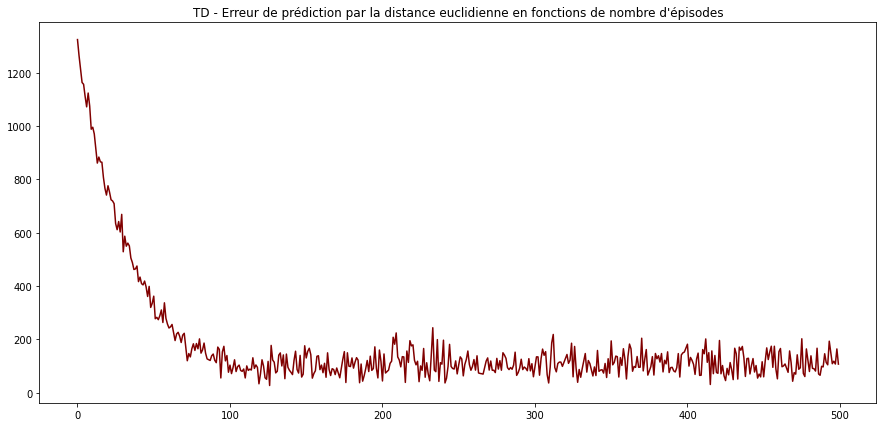

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(td_score,  color="maroon")
plt.title("TD - Erreur de prédiction par la distance euclidienne en fonctions de nombre d'épisodes")
plt.show()


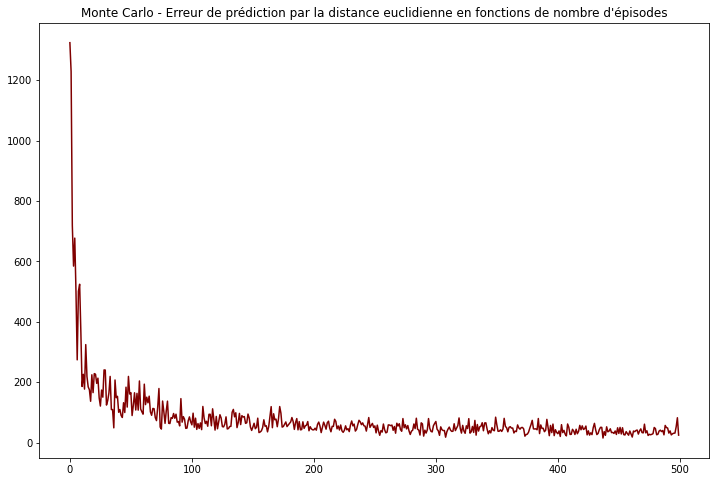

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(mc_score,  color="maroon")
plt.title("Monte Carlo - Erreur de prédiction par la distance euclidienne en fonctions de nombre d'épisodes")
plt.show()


### Remarques

Les deux courbes obtenues suivent la même evolution: plus le nombre d'épisodes augmente, plus le taux d'erreurs diminue.

## **Question 3**

Dans cette question il s'agit d'implémenter les algorithmes: n-steps TD(0) et  TD(λ).

### **Implementation**

In [ ]:
def td_n(policy, env, gamma, alpha, nb_episode, n):
    n_state=env.get_nb_states()
    T=np.zeros(n_state)

    for i in range(nb_episode):
      terminal = False
      state = env.reset()
      tab =[]
      tab.append(0)
      states = []
      states.append(state) 
      while not terminal:
        action=np.random.choice(4,p=policy[state])
        nvState,r,terminal, info= env.step(action)
        tab.append(r)
        states.append(nvState)
        state = nvState

      if len(states) > n:
        for s,state_ in enumerate(states):
          if len(states[s:]) > n:
            G = sum([gamma**(i_-1) * tab[s+i_] for i_ in range(1,n+1)]) + (gamma**n) * T[states[s+n]]
            T[state_] = T[state_] + alpha * (G - T[state_])
            
    return T

In [ ]:
def td_lambda(pi, nb_episode, env, alpha, gamma, lambda_):
    n_state = env.get_nb_states()
    T = np.zeros(n_state)
    for i in range(nb_episode):
        terminal = False
        state = env.reset()
        tab = np.zeros(n_state)
        while not terminal:
            action = np.random.choice(4, p=pi[state])
            nvstate, r, terminal, info = env.step(action)
            delta = r+gamma*T[nvstate]-T[state]
            for s in range(n_state):
                tab[s] = gamma*lambda_*tab[s]
                if state == s:
                     tab[s] += 1
            for s in range(n_state):
                T[s] += alpha*delta*tab[s]
            state = nvstate
    return T

### **Application**

In [ ]:
gamma=0.9
alpha=0.1
v_IPE=ipe(policy,env,0.9,0.1)

In [ ]:
td_score_2=[]
td_score_5=[]
td_score_10=[]

for p in range(1,500,20):
  td_score_2.append(np.sqrt(np.sum((td_n(policy, env, gamma, alpha, p, 2)-ipe(policy,env,0.9,0.1))**2)))
  td_score_5.append(np.sqrt(np.sum((td_n(policy, env, gamma, alpha, p, 5)-ipe(policy,env,0.9,0.1))**2)))
  td_score_10.append(np.sqrt(np.sum((td_n(policy, env, gamma, alpha, p, 10)-ipe(policy,env,0.9,0.1))**2)))

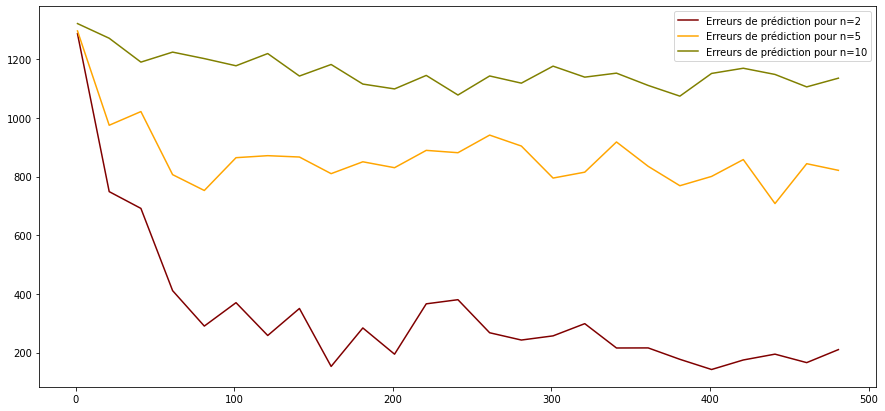

In [ ]:
y=[i for i in range(1,500,20)]
plt.figure(figsize=(15,7))
plt.plot(y, td_score_2,label="Erreurs de prédiction pour n=2", color="maroon")
plt.plot(y, td_score_5,label="Erreurs de prédiction pour n=5", color="orange")
plt.plot(y, td_score_10,label="Erreurs de prédiction pour n=10", color="olive")
plt.legend()
plt.show()

In [ ]:
td_lambda_score_2=[]
td_lambda_score_5=[]
td_lambda_score_10=[]

for p in range(1,500,20):
  td_lambda_score_2.append(np.sqrt(np.sum((td_lambda(policy,p, env,  alpha, gamma, 0.1)-ipe(policy,env,0.9,0.01))**2)))
  td_lambda_score_5.append(np.sqrt(np.sum((td_lambda(policy,p, env, alpha, gamma, 0.5)-ipe(policy,env,0.9,0.01))**2)))
  td_lambda_score_10.append(np.sqrt(np.sum((td_lambda(policy,p, env, alpha, gamma, 1)-ipe(policy,env,0.9,0.01))**2)))

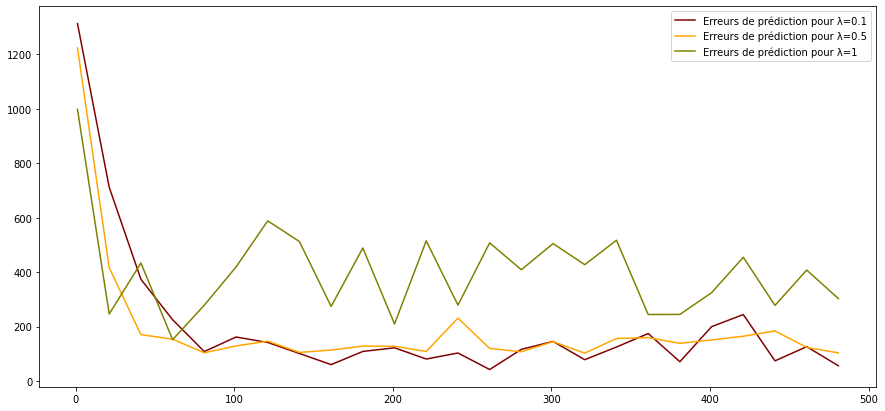

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(y, td_lambda_score_2,label="Erreurs de prédiction pour λ=0.1", color="maroon")
plt.plot(y, td_lambda_score_5,label="Erreurs de prédiction pour λ=0.5", color="orange")
plt.plot(y, td_lambda_score_10,label="Erreurs de prédiction pour λ=1", color="olive")

plt.legend()
plt.show()

# Exercice 2

Le but de cet exercice est d'implementer differents algorithmes vu en cours d'apprentissage par renforcement pour le contrôle.  
Pour rappel, ces algorithmes permettent de trouver le *meilleur chemin.*

Pour chacune des méthodes demandées, nous afficherons des graphiques montrant l’évolution du total des récompenses par épisode et du nombre 
d’actions exécutées par épisode, au fur-et-à mesure des épisodes.  
Nous avons fait varier le nombre d'épisodes et $\epsilon$ (nous avons pris **3** valeurs pour tous les tests à savoir: *0.1 et 0.5 et 1.* 

## **Question 1**

Pour commencer, nous devons implementer les algorithmes Monte-carlo, Sarsa et QLearning suivant la politique suivante:

**$\dfrac{ϵ_0}{\sqrt(t-T)}$ si t>T,**   
**$ϵ_0$ sinon**

In [ ]:
env=base.Maze()

### **Implementation**

In [ ]:
def greedy_policy(qvalues):
    policy = np.zeros(qvalues.shape)
    for s, va in enumerate(qvalues):
        policy[s, np.argmax(va)] = 1
    return policy

In [ ]:
def egreedy_policy(qvalues, epsilon):
    nbactions = qvalues.shape[1]
    policy = np.ones(qvalues.shape) * epsilon /nbactions
    for s, va in enumerate(qvalues):
        policy[s, np.argmax(va)] += 1 - epsilon
    return policy

In [ ]:
def monte_carlo(env, gamma, nb_episodes, epsilon, T):
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))
    n = np.zeros((env.get_nb_states(), nba))
    
    policy = np.ones((env.get_nb_states(), nba)) / nba #proba egale partout

    liste_recomp=[]
    liste_action=[]
    for t in range(nb_episodes): #on doit avoir un certain nombre d'episode
        state = env.reset()
        episode = [] #on reinitialise les liste d'episode

        #les actions qui vont etre faites jusqu'a arriver a l'etat final
        while not env.is_final(state):
            action = np.random.choice(nba, p=policy[state])
            nvstate, r, _, _ = env.step(action)
            episode.append([state, action, r, nvstate]) #on construit l'épisode
            state = nvstate
            
        #calcul de N et Q
        g = 0 # retour
        for s, a, r, ns in reversed(episode):
            g = r + gamma * g
            n[s, a] += 1
            q[s, a] += (g - q[s,a])/n[s, a]

        #ameliorer la politique 
        if t<=T:    
          policy = egreedy_policy(q, epsilon)
        else:
          epsilon_t=epsilon/(sqrt(t-T))
          policy = egreedy_policy(q, epsilon_t)
        
        #stocker 
        liste_recomp.append(episode[len(episode)-1][2])
        liste_action.append(len(episode))
        


    return q,liste_recomp,liste_action

In [ ]:
#permet de choisir l'action, utile quand l'episode ne doit pas se terminer
def egreedy_decision(qvalues, state, epsilon):
    if np.random.rand()<epsilon:
        return np.random.randint(0, qvalues.shape[1])
    else:
        return np.argmax(qvalues[state])

In [ ]:
def sarsa(env, gamma, alpha, nb_episodes, epsilon, T):
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))
    liste_recomp=[]
    liste_action=[]

    for t in range(nb_episodes):
        nb_action=1
        state = env.reset()

        if t<=T:    
          action = egreedy_decision(q, state, epsilon)
        else:
          epsilon_t=epsilon/(sqrt(t-T))
          action = egreedy_decision(q, state, epsilon_t)

        while not env.is_final(state):
            nvstate, r, final, _ = env.step(action)

            if t<=T:    
              nvaction = egreedy_decision(q, nvstate, epsilon)
            else:
              epsilon_t=epsilon/(sqrt(t-T))
              nvaction = egreedy_decision(q, nvstate, epsilon_t)  

            if final:
                target = r
            else:
                target = r + gamma * q[nvstate, nvaction]
        
            q[state, action] += alpha * (target - q[state, action])
            
            state = nvstate
            action = nvaction
            nb_action+=1
        
        #stocker 
        liste_recomp.append(target)
        liste_action.append(nb_action)
    
    return q,liste_recomp,liste_action

In [ ]:
def egreedy_policy(qvalues, epsilon):
    nbactions = qvalues.shape[1]
    policy = np.ones(qvalues.shape) * epsilon /nbactions
    for s, va in enumerate(qvalues):
        policy[s, np.argmax(va)] += 1 - epsilon
    return policy

In [ ]:
def qlearning(env, gamma, alpha, nb_episodes, epsilon, T):
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))
    liste_recomp=[]
    liste_action=[]

    for t in range(nb_episodes):
        state = env.reset()
        nb_action=0
        while not env.is_final(state):
            if t<=T:    
              action = egreedy_decision(q, state, epsilon)
            else:
              epsilon_t=epsilon/(sqrt(t-T))
              action = egreedy_decision(q, state, epsilon_t)

            nvstate, r, final, _ = env.step(action)
            
            if final:
                target = r
            else:
                target = r + gamma * np.max(q[nvstate])     
            q[state, action] += alpha * (target - q[state, action])
            state = nvstate
            nb_action+=1

                    
        #stocker 
        liste_recomp.append(target)
        liste_action.append(nb_action)
    
    
    return q,liste_recomp,liste_action

### **Application sur l'environnement Maze**

#### T=5 et différentes valeurs de $\epsilon$

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 0.5, 5)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500,0.5, 5)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500,0.5, 5)

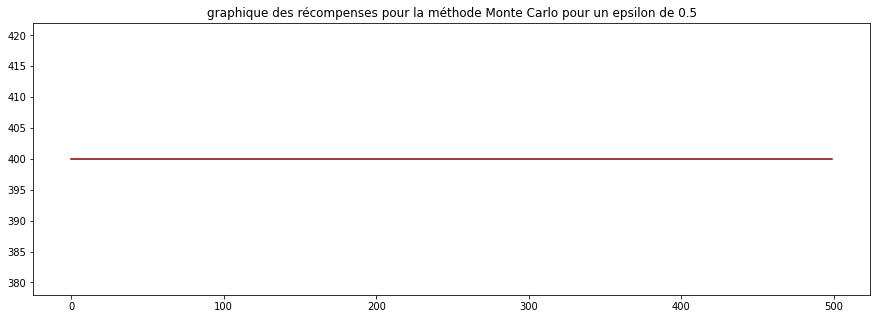

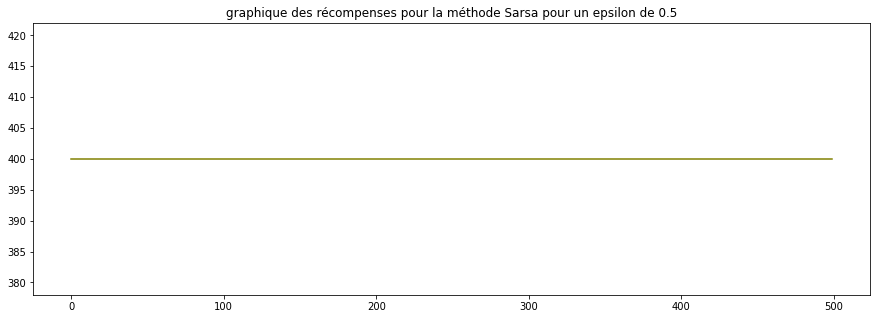

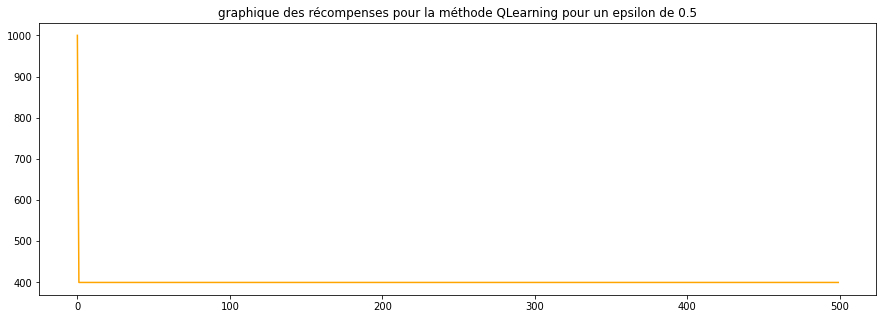

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 0.5")
plt.show()

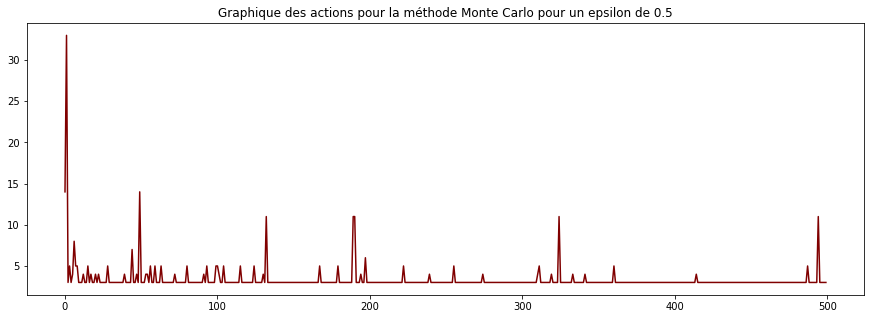

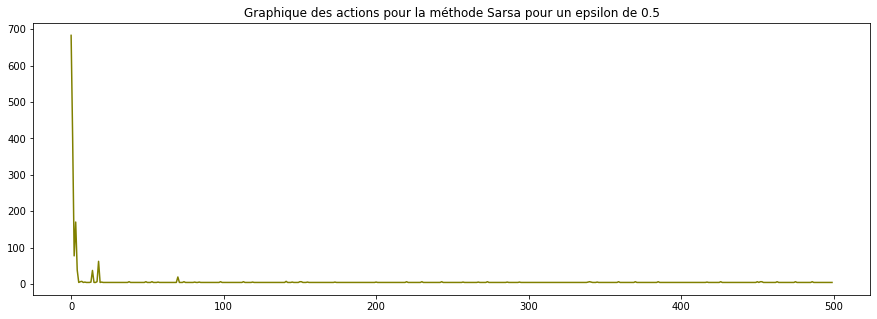

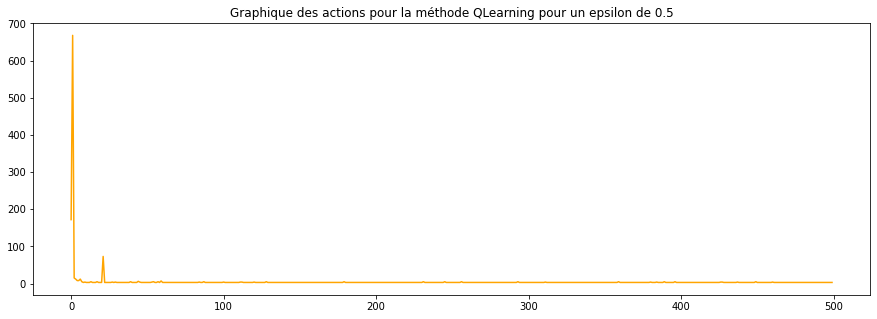

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 0.5")
plt.show()

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 0.1, 5)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500, 0.1, 5)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500, 0.1, 5)

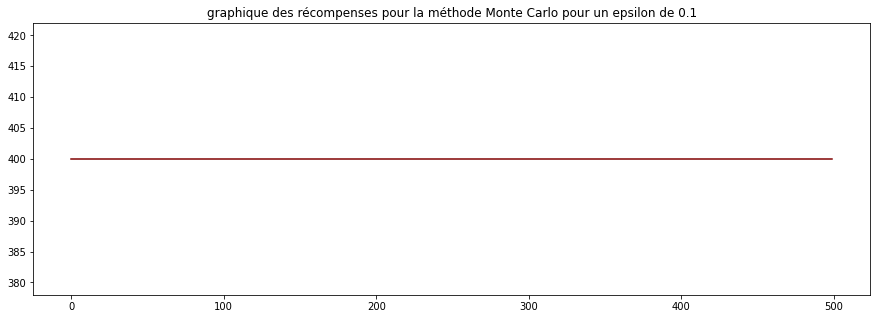

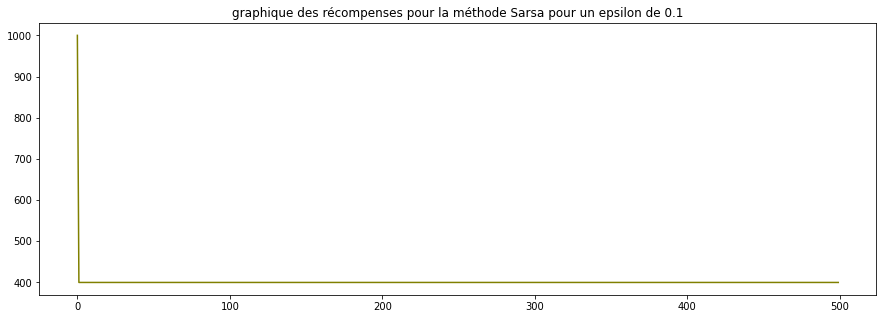

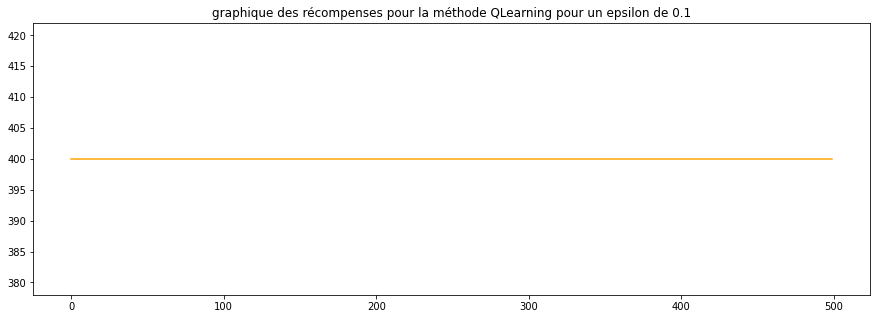

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 0.1")
plt.show()

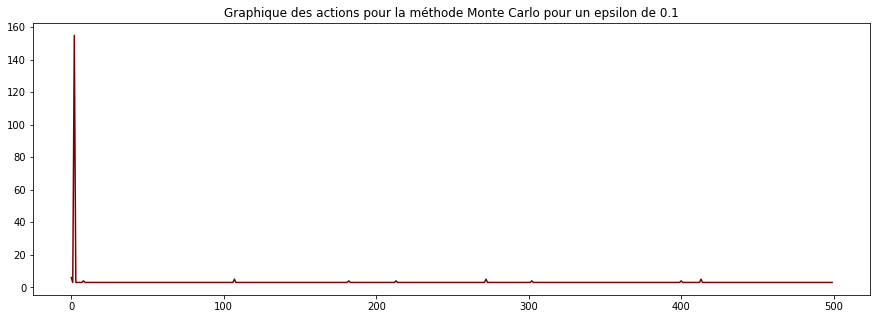

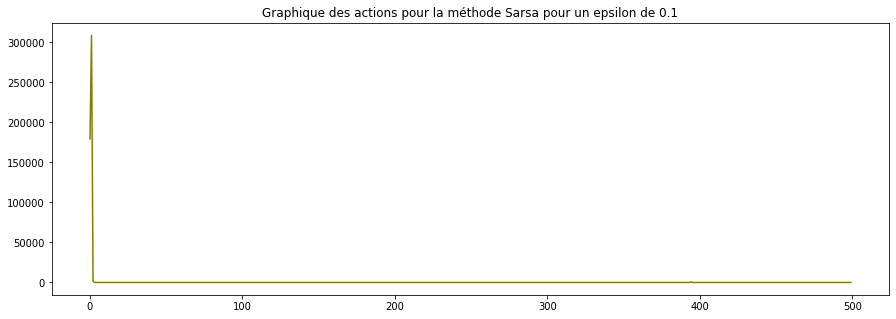

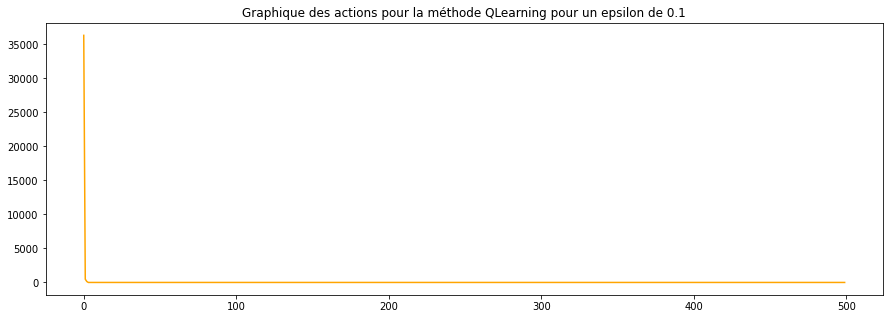

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 0.1")
plt.show()

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 1, 5)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500,1, 5)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500,1, 5)

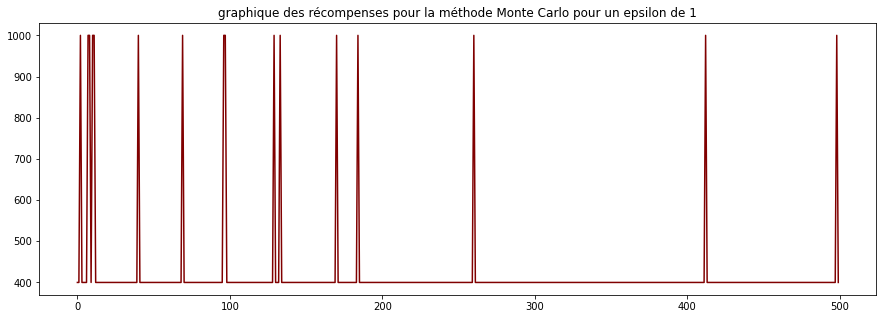

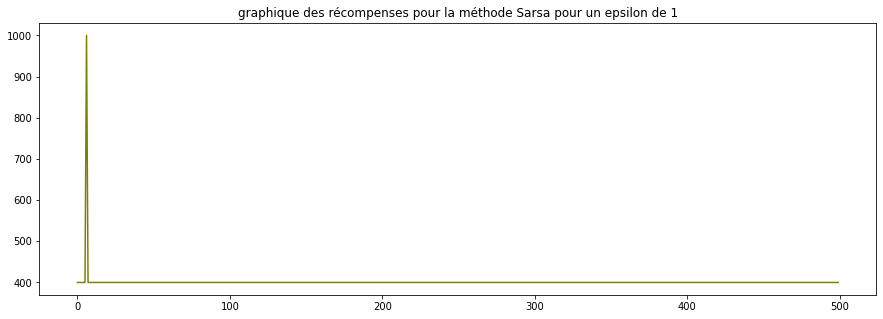

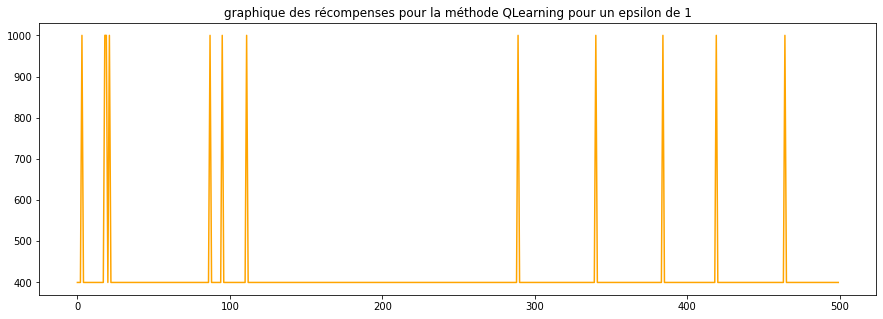

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 1")
plt.show()

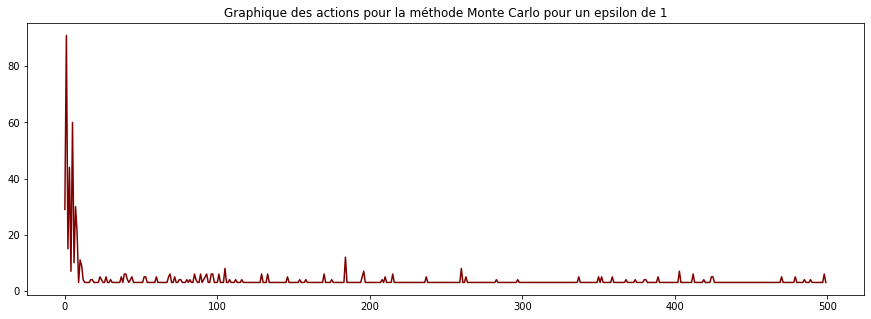

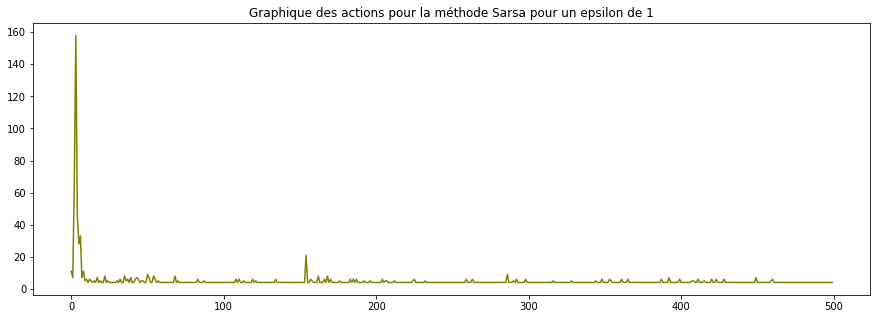

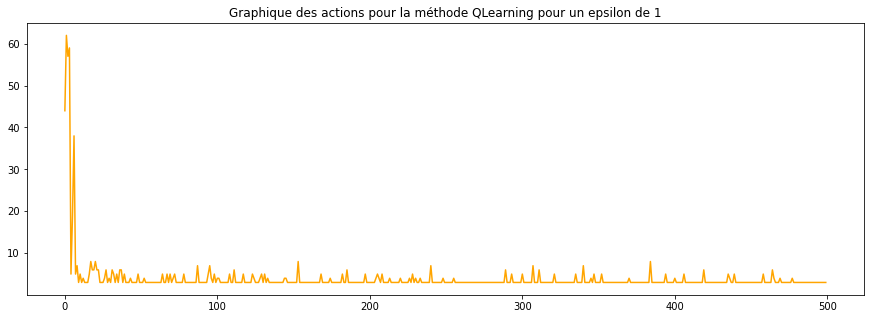

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 1")
plt.show()

#### T=200 et différentes valeurs de $\epsilon$

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 0.5, 200)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500,0.5, 200)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500,0.5, 200)

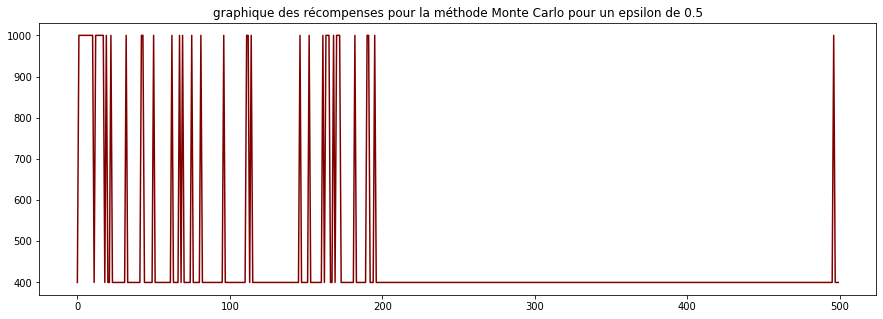

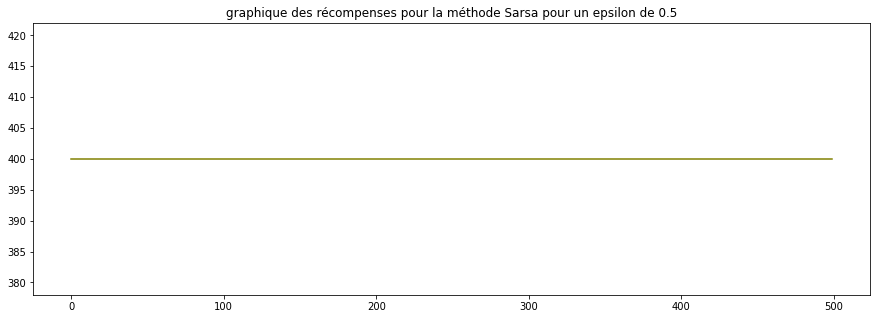

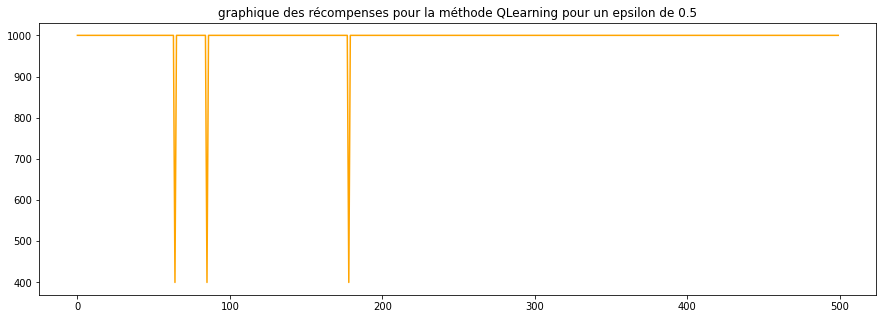

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 0.5")
plt.show()

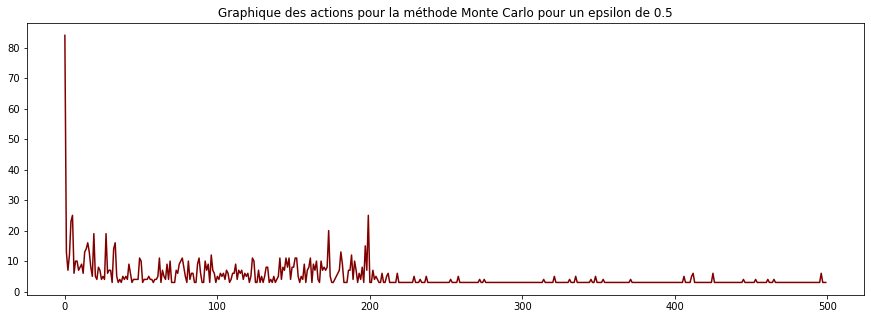

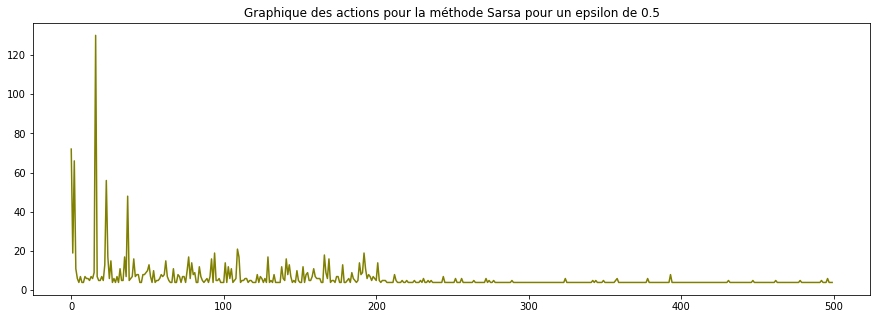

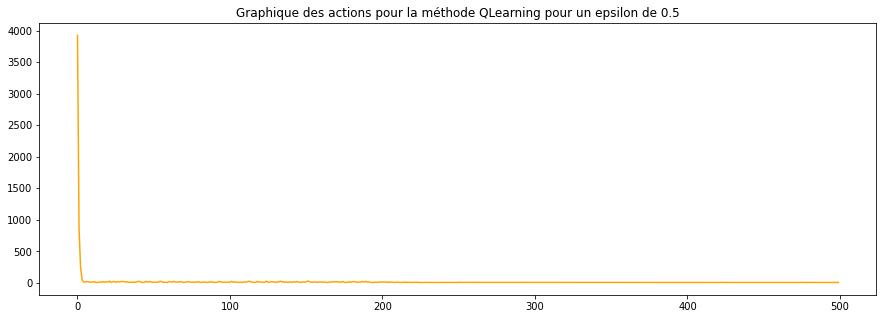

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 0.5")
plt.show()

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 0.1, 200)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500, 0.1, 200)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500, 0.1, 200)

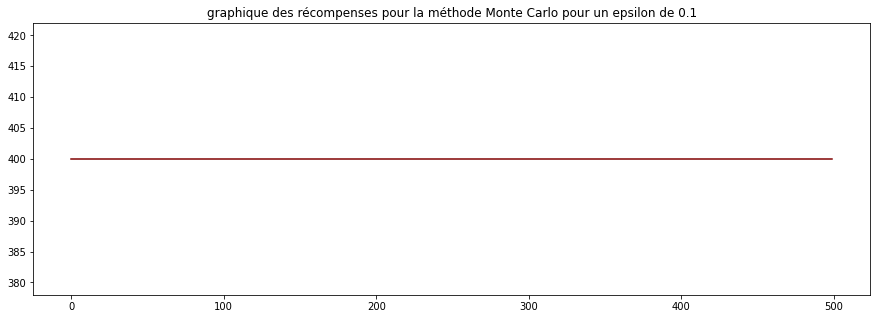

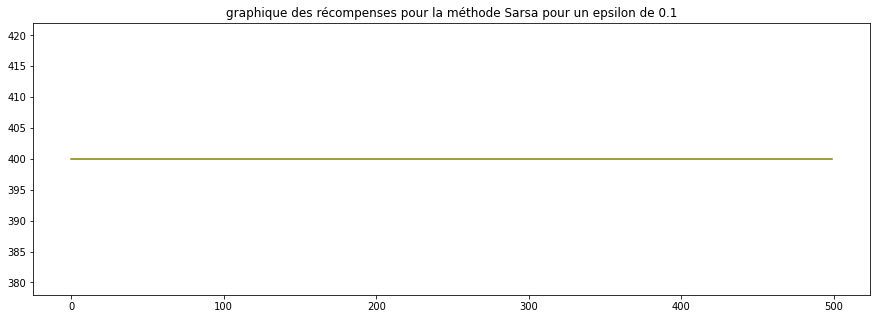

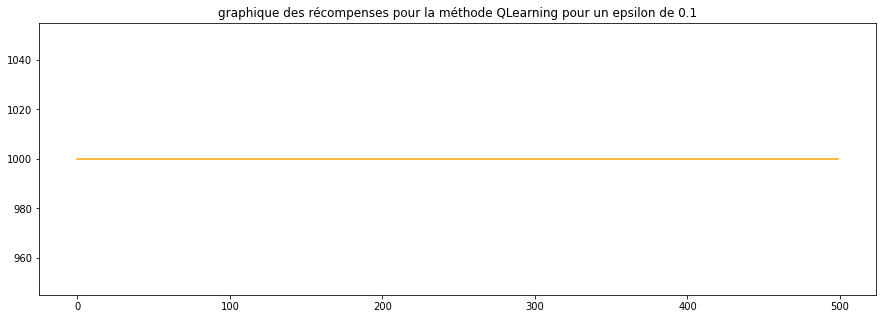

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 0.1")
plt.show()

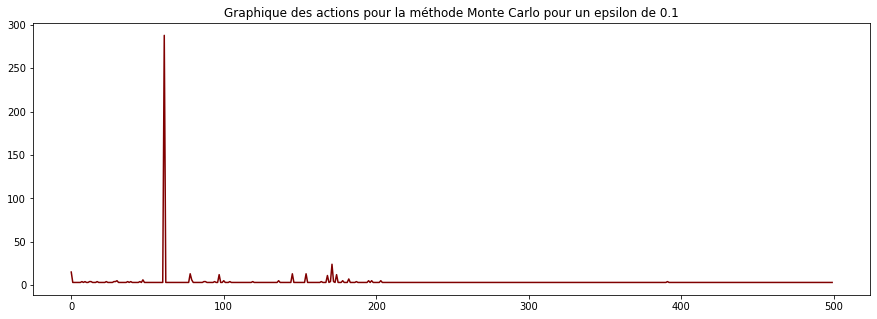

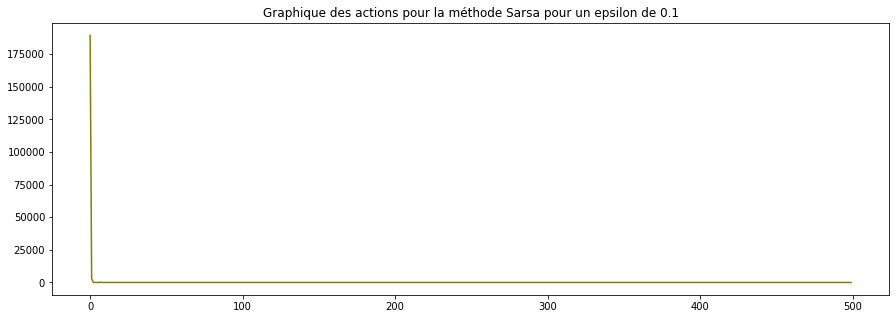

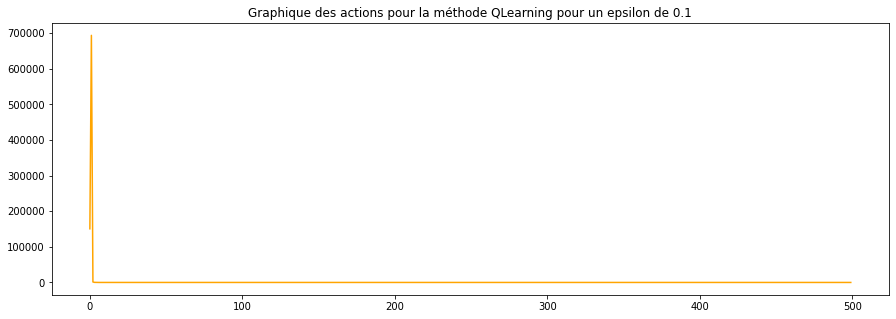

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 0.1")
plt.show()

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 1, 200)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500,1, 200)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500,1, 200)

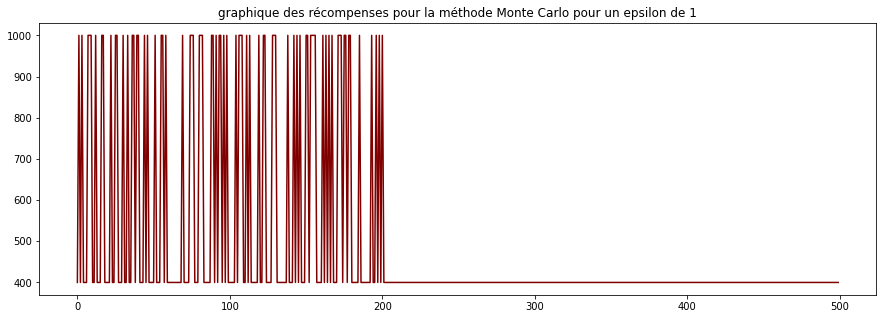

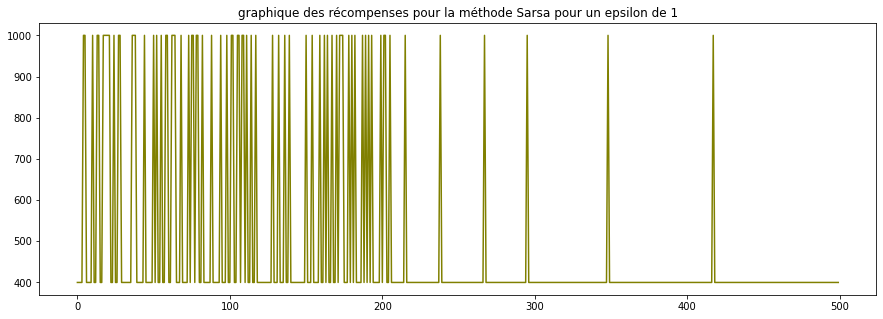

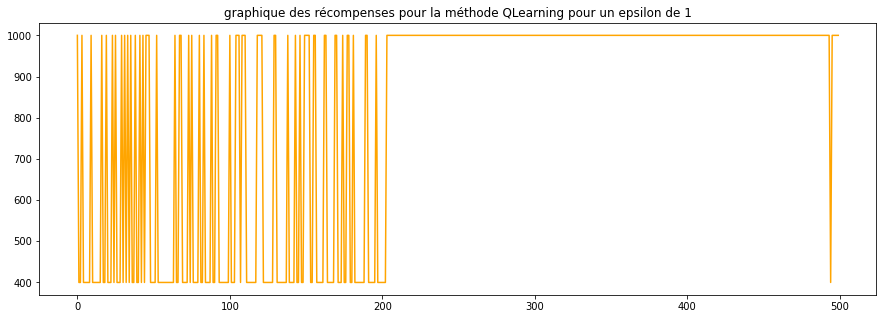

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 1")
plt.show()

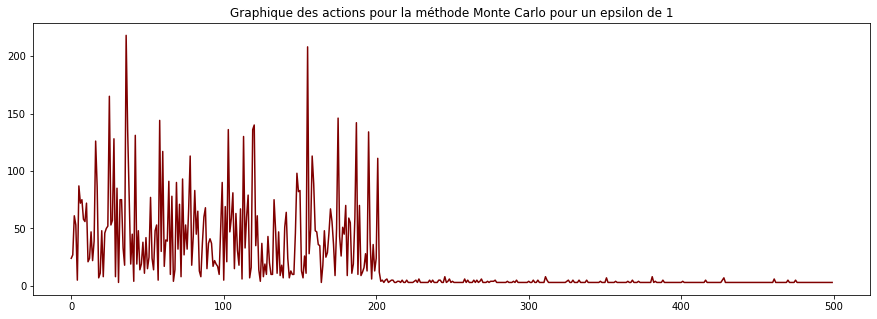

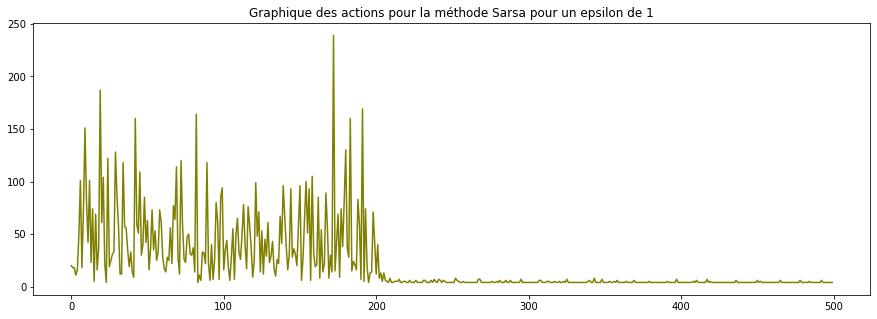

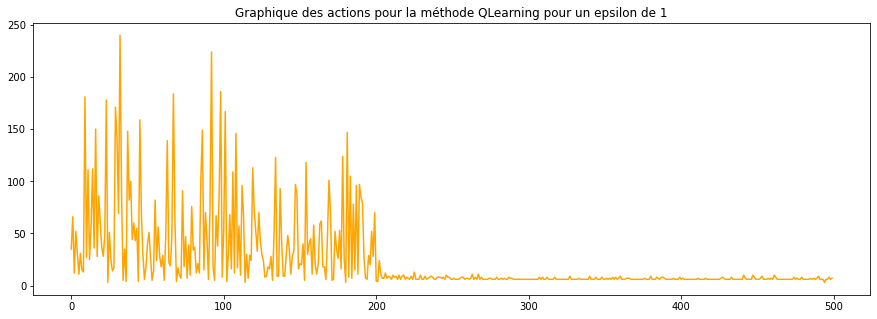

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 1")
plt.show()

#### T=400 et différentes valeurs de $\epsilon$

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 0.5, 400)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500,0.5, 400)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500,0.5, 400)

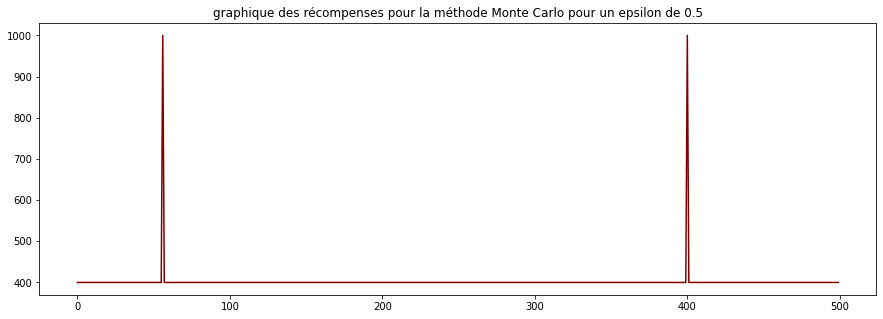

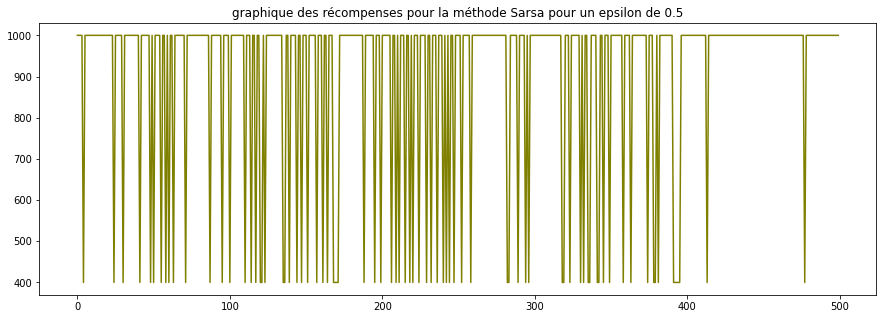

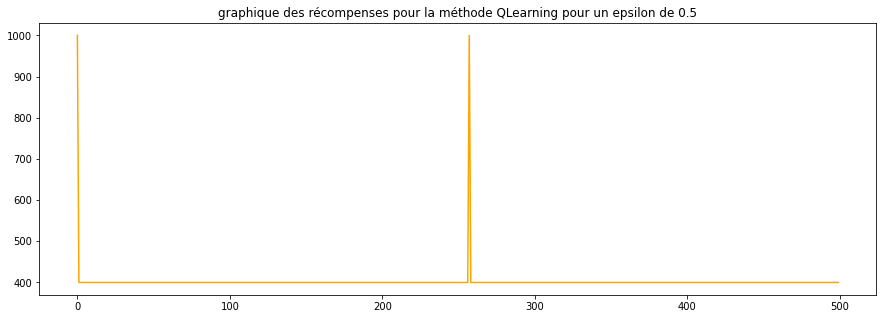

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 0.5")
plt.show()

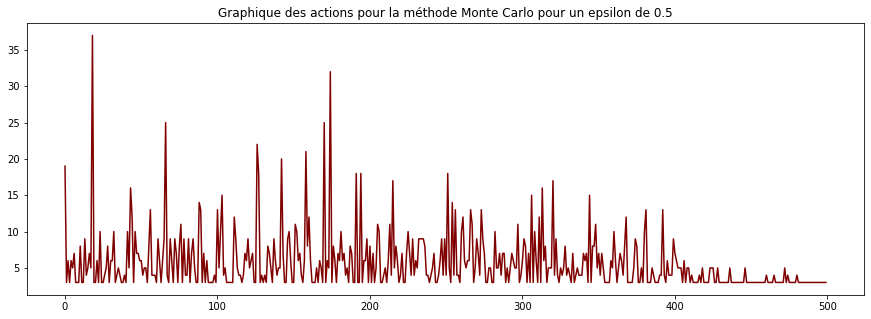

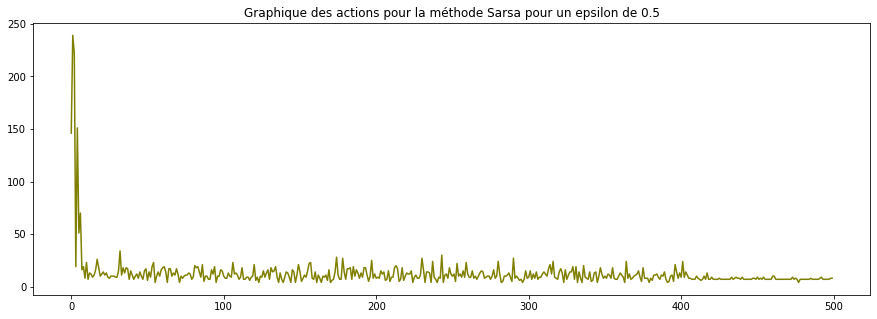

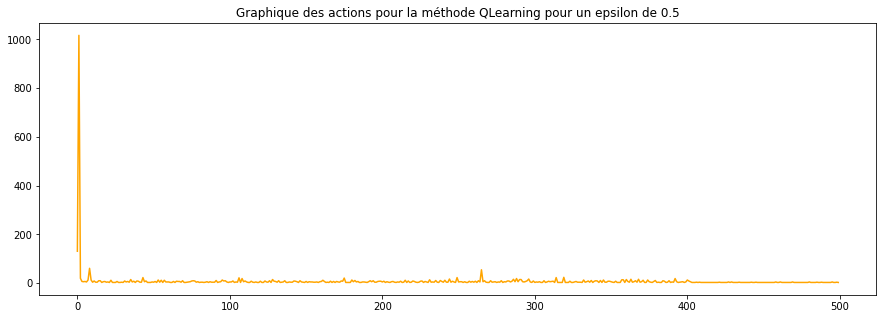

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 0.5")
plt.show()

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 0.1, 400)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500, 0.1, 400)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500, 0.1, 400)

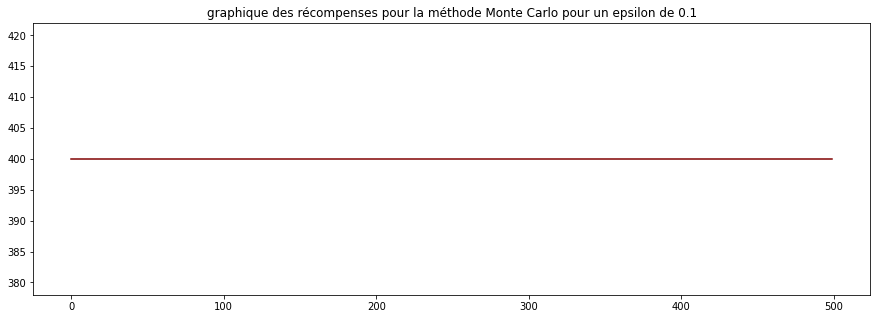

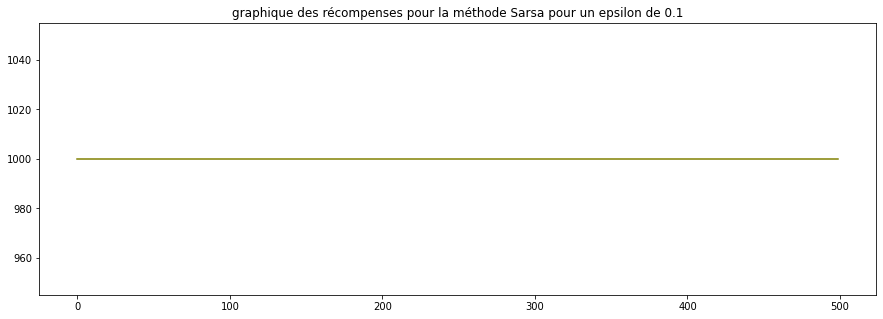

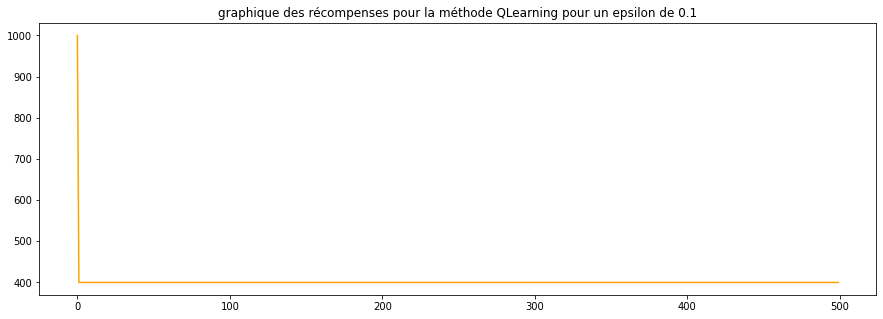

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 0.1")
plt.show()

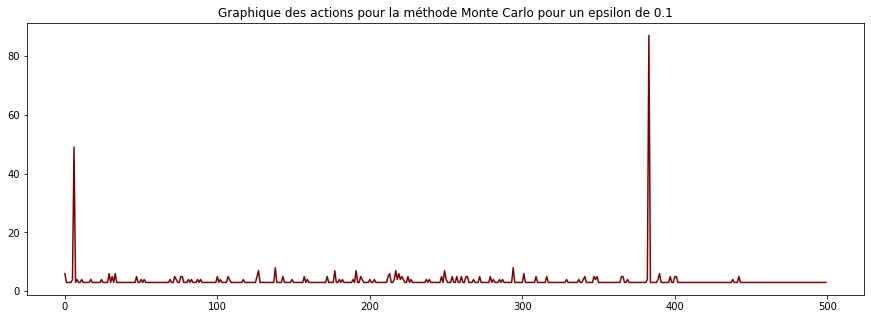

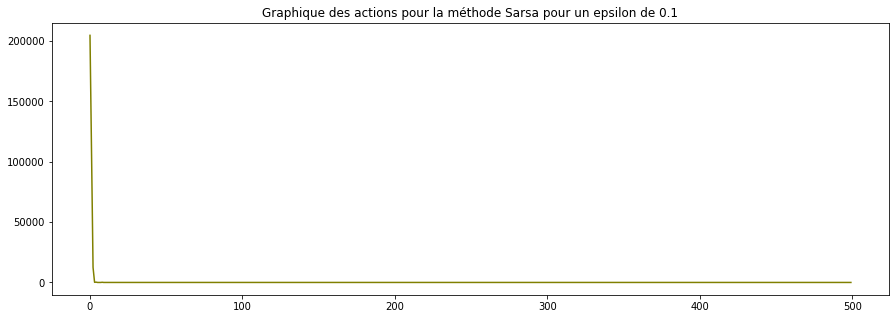

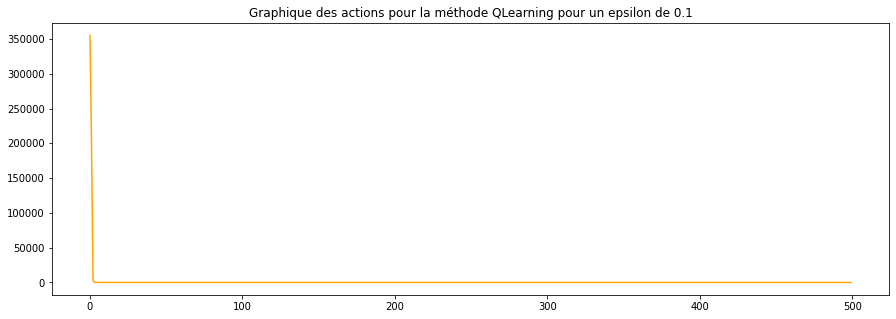

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 0.1")
plt.show()

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 1, 400)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500,1, 400)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500,1, 400)

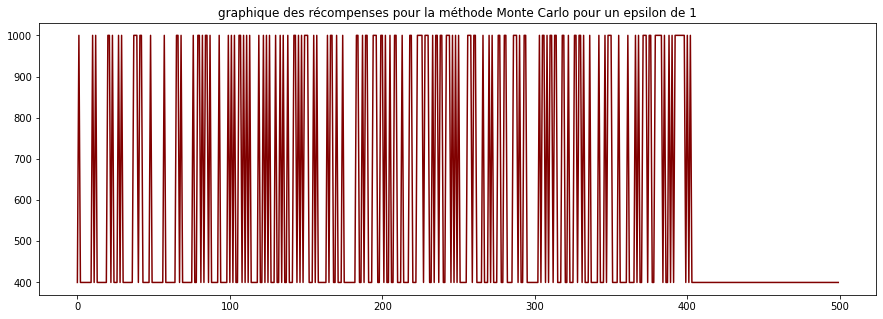

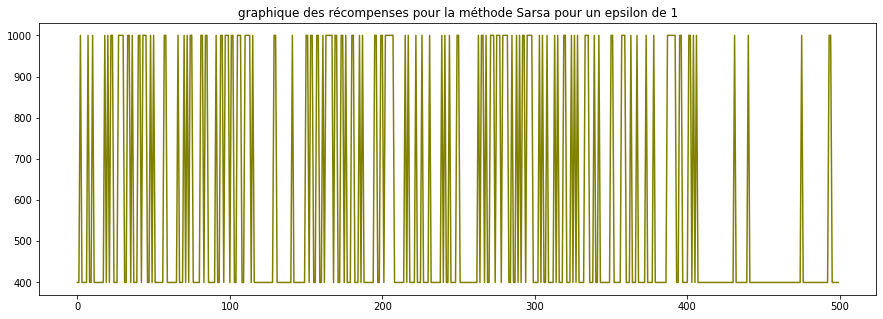

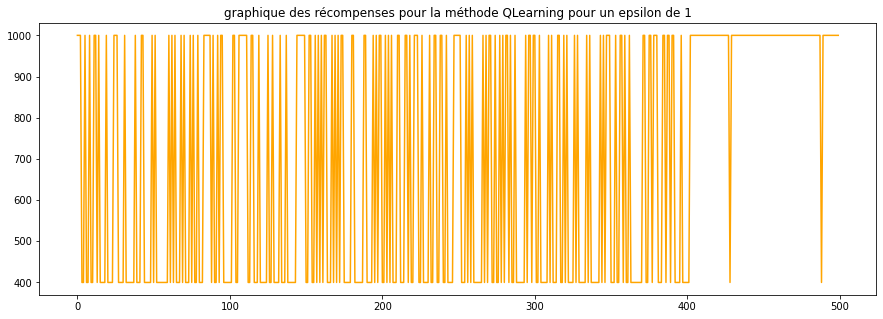

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 1")
plt.show()

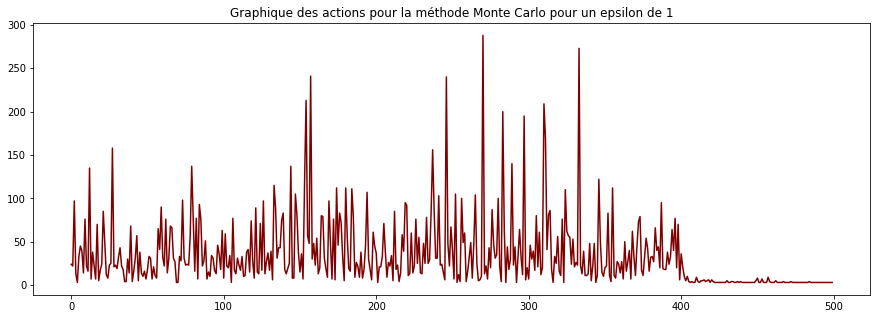

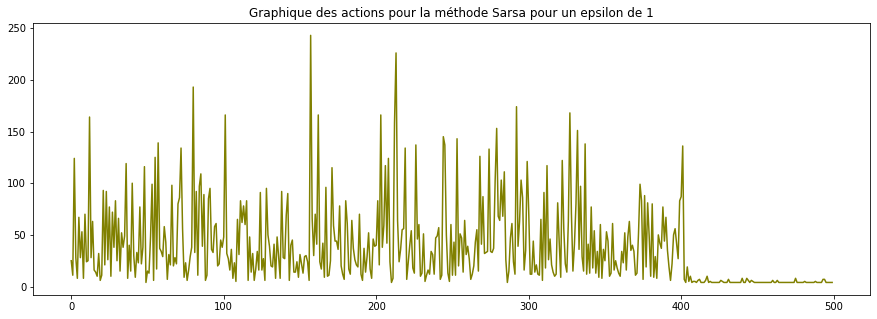

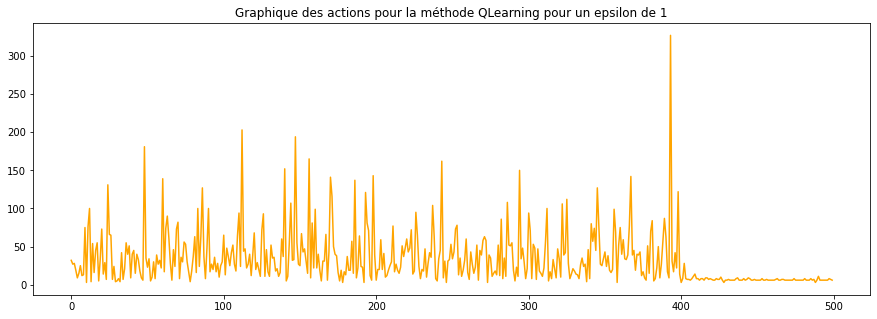

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 1")
plt.show()

#### **Remarques**

**Pour T=5:**  
Pour les différentes valeurs d'$\epsilon$ les courbes sont plutôt similaires pour les 3 algorithmes: Monte-Carlo, Sarsa, QLearning.  
La courbe des actions atteint une valeur maximale au tout début, et s'annule pratiquement après 5 épisodes (ce qui correspond au T fixé).  
Nous remarquons que les differentes valeurs d'$\epsilon$ *n'inffluence pas le noombre d'actions du Monte-Carlo* (une centaine) contrairement au *Sarsa et au QLearning*, où les valeurs explosent dépendemment de l'$\epsilon$: des disainse de milliers pour les petites valeurs d'$\epsilon$ à même une centaine pour les grandes valeurs d'$\epsilon$.
  
**Pour T=200:**  
D'une maniere générale, plus la valeur d'$\epsilon$ augmente, plus les valeurs des actions oscillent entre 0 et 200 pour s'annuler après T.  
Les valeurs des actions sont également influencées par $\epsilon$, quand $\epsilon$ est petit, la valeur des actions est très grande. 
  

**Pour T=400:**   
Les graphiques obtenus confirment les observations remarquées en T=200.

   

**Pour les differentes valeurs de T**, les courbes des récompenses sont plutôt similaires (valeur fixe à 400 ou à 1000) ou oscillent légérement entre ces deux valeurs pour les différents épisodes.  

## **Question 2**

Dans cette partie, il s'agit d'implementer méthodes permettant d'évaluer la politique à savoir: 


*   Softmax.
*   Greedy avec une initialisation optimiste.


### **Implementation**

#### **Exploration egreedy**

In [ ]:
def greedy_policy(qvalues):
    policy = np.zeros(qvalues.shape)
    for s, va in enumerate(qvalues):
        policy[s, np.argmax(va)] = 1
    return policy

In [ ]:
def egreedy_policy(qvalues, epsilon):
    nbactions = qvalues.shape[1]
    policy = np.ones(qvalues.shape) * epsilon /nbactions
    for s, va in enumerate(qvalues):
        policy[s, np.argmax(va)] += 1 - epsilon
    return policy

In [ ]:
def monte_carlo_egreedy(env, gamma, nb_episodes, epsilon, T):
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))
    n = np.zeros((env.get_nb_states(), nba))
    
    policy = np.ones((env.get_nb_states(), nba)) / nba #proba egale partout

    liste_recomp=[]
    liste_action=[]
    for t in range(nb_episodes): #on doit avoir un certain nombre d'episode
        state = env.reset()
        episode = [] #on reinitialise les liste d'episode

        #les actions qui vont etre faites jusqu'a arriver a l'etat final
        while not env.is_final(state):
            action = np.random.choice(nba, p=policy[state])
            nvstate, r, _, _ = env.step(action)
            episode.append([state, action, r, nvstate]) #on construit l'épisode
            state = nvstate
            
        #calcul de N et Q
        g = 0 # retour
        for s, a, r, ns in reversed(episode):
            g = r + gamma * g
            n[s, a] += 1
            q[s, a] += (g - q[s,a])/n[s, a]

        #ameliorer la politique 
        if t<=T:    
          policy = egreedy_policy(q, epsilon)
        else:
          epsilon_t=epsilon/(sqrt(t-T))
          policy = egreedy_policy(q, epsilon_t)
        
        #stocker 
        liste_recomp.append(episode[len(episode)-1][2])
        liste_action.append(len(episode))
        


    return q,liste_recomp,liste_action

In [ ]:
def egreedy_decision(qvalues, state, epsilon):
    if np.random.rand()<epsilon:
        return np.random.randint(0, qvalues.shape[1])
    else:
        return np.argmax(qvalues[state])

In [ ]:
def sarsa_egreedy(env, gamma, alpha, nb_episodes, epsilon, T):
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))
    liste_recomp=[]
    liste_action=[]

    for t in range(nb_episodes):
        nb_action=1
        state = env.reset()

        if t<=T:    
          action = egreedy_decision(q, state, epsilon)
        else:
          epsilon_t=epsilon/(sqrt(t-T))
          action = egreedy_decision(q, state, epsilon_t)

        while not env.is_final(state):
            nvstate, r, final, _ = env.step(action)

            if t<=T:    
              nvaction = egreedy_decision(q, nvstate, epsilon)
            else:
              epsilon_t=epsilon/(sqrt(t-T))
              nvaction = egreedy_decision(q, nvstate, epsilon_t)  

            if final:
                target = r
            else:
                target = r + gamma * q[nvstate, nvaction]
        
            q[state, action] += alpha * (target - q[state, action])
            
            state = nvstate
            action = nvaction
            nb_action+=1
        
        #stocker 
        liste_recomp.append(target)
        liste_action.append(nb_action)
    
    return q,liste_recomp,liste_action

In [ ]:
def qlearning_egreedy(env, gamma, alpha, nb_episodes, epsilon, T):
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))
    liste_recomp=[]
    liste_action=[]

    for t in range(nb_episodes):
        state = env.reset()
        nb_action=0
        while not env.is_final(state):
            if t<=T:    
              action = egreedy_decision(q, state, epsilon)
            else:
              epsilon_t=epsilon/(sqrt(t-T))
              action = egreedy_decision(q, state, epsilon_t)

            nvstate, r, final, _ = env.step(action)
            
            if final:
                target = r
            else:
                target = r + gamma * np.max(q[nvstate])     
            q[state, action] += alpha * (target - q[state, action])
            state = nvstate
            nb_action+=1

                    
        #stocker 
        liste_recomp.append(target)
        liste_action.append(nb_action)
    
    
    return q,liste_recomp,liste_action

#### **Exploration softmax**

In [ ]:
def softmax_policy(qvalues, T):
    policy = np.zeros(qvalues.shape)
    for state in range(qvalues.shape[0]):
      for action in range(qvalues.shape[1]):
        num = np.exp(qvalues[state,action]/T)
        denom = sum(np.exp(val/T) for val in qvalues[state,:])
        policy[state,action] = num/denom
    return policy

In [ ]:
def monte_carlo_softmax(env, gamma, nb_episodes, T):
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))
    n = np.zeros((env.get_nb_states(), nba))
    
    policy = np.ones((env.get_nb_states(), nba)) / nba #proba egale partout

    liste_recomp=[]
    liste_action=[]
    for t in range(nb_episodes): #on doit avoir un certain nombre d'episode
        state = env.reset()
        episode = [] #on reinitialise les liste d'episode

        #les actions qui vont etre faites jusqu'a arriver a l'etat final
        while not env.is_final(state):
            action = np.random.choice(nba, p=policy[state])
            nvstate, r, _, _ = env.step(action)
            episode.append([state, action, r, nvstate]) #on construit l'épisode
            state = nvstate
            
        #calcul de N et Q
        g = 0 # retour
        for s, a, r, ns in reversed(episode):
            g = r + gamma * g
            n[s, a] += 1
            q[s, a] += (g - q[s,a])/n[s, a]

        #ameliorer la politique 
        policy = softmax_policy(q, T)
        
        #stocker 
        liste_recomp.append(episode[len(episode)-1][2])
        liste_action.append(len(episode))
        


    return q,liste_recomp,liste_action

In [ ]:
def softmax_decision(qvalues, state, T):
    prob = np.zeros(qvalues.shape[1])
    for action in range(qvalues.shape[1]):
        num = np.exp(qvalues[state,action]/T)
        denom = sum(np.exp(val/T) for val in qvalues[state,:])
        prob[action] = num/denom
    return np.random.choice(len(prob), p=prob)

In [ ]:
def sarsa_softmax(env, gamma, alpha, nb_episodes, T):
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))
    liste_recomp=[]
    liste_action=[]

    for t in range(nb_episodes):
        nb_action=1
        state = env.reset()

        action = softmax_decision(q, state, T)

        while not env.is_final(state):
            nvstate, r, final, _ = env.step(action)

            nvaction = softmax_decision(q, nvstate, T)  

            if final:
                target = r
            else:
                target = r + gamma * q[nvstate, nvaction]
        
            q[state, action] += alpha * (target - q[state, action])
            state = nvstate
            action = nvaction
            nb_action+=1
        
        #stocker 
        liste_recomp.append(target)
        liste_action.append(nb_action)
    
    return q,liste_recomp,liste_action

In [ ]:
def qlearning_softmax(env, gamma, alpha, nb_episodes, T):
    nba = env.get_nb_actions()
    q = np.zeros((env.get_nb_states(), nba))
    liste_recomp=[]
    liste_action=[]

    for t in range(nb_episodes):
        state = env.reset()
        nb_action=0
        while not env.is_final(state):
            action = softmax_decision(q, state, T)

            nvstate, r, final, _ = env.step(action)
            
            if final:
                target = r
            else:
                target = r + gamma * np.max(q[nvstate])     
            q[state, action] += alpha * (target - q[state, action])
            state = nvstate
            nb_action+=1

                    
        #stocker 
        liste_recomp.append(target)
        liste_action.append(nb_action)
    
    
    return q,liste_recomp,liste_action

#### **Exploration optimiste**

In [ ]:
def greedy_decision(qvalues, state):
  return np.argmax(qvalues[state])

In [ ]:
def sarsa_optimiste(env, gamma, alpha, nb_episodes):
    nba = env.get_nb_actions()
    q = np.full((env.get_nb_states(), nba), env.get_max_reward()/(1-gamma))
    liste_recomp=[]
    liste_action=[]

    for t in range(nb_episodes):
        nb_action=1
        state = env.reset()
        action = greedy_decision(q, state)

        while not env.is_final(state):
            nvstate, r, final, _ = env.step(action)

            nvaction = greedy_decision(q, nvstate)  

            if final:
                target = r
            else:
                target = r + gamma * q[nvstate, nvaction]
        
            q[state, action] += alpha * (target - q[state, action])
            
            state = nvstate
            action = nvaction
            nb_action+=1
        
        #stocker 
        liste_recomp.append(target)
        liste_action.append(nb_action)
    
    return q,liste_recomp,liste_action

In [ ]:
def qlearning_optimiste(env, gamma, alpha, nb_episodes):
    nba = env.get_nb_actions()
    q = np.full((env.get_nb_states(), nba), env.get_max_reward()/(1-gamma))
    liste_recomp=[]
    liste_action=[]

    for t in range(nb_episodes):
        state = env.reset()
        nb_action=0
        while not env.is_final(state):
            action = greedy_decision(q, state)

            nvstate, r, final, _ = env.step(action)
            
            if final:
                target = r
            else:
                target = r + gamma * np.max(q[nvstate])     
            q[state, action] += alpha * (target - q[state, action])
            state = nvstate
            nb_action+=1

                    
        #stocker 
        liste_recomp.append(target)
        liste_action.append(nb_action)
    
    
    return q,liste_recomp,liste_action

### **Application**

#### **a. Exploration softmax**

##### **T=5**

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo_softmax(env, 0.5, 500, 5)
q_sarsa,recomp_sarsa,action_sarsa=sarsa_softmax(env, 0.9, 0.1, 500, 5)
q_qlearning,recomp_qlearning,action_qlearning=qlearning_softmax(env, 0.9, 0.1, 500, 5)

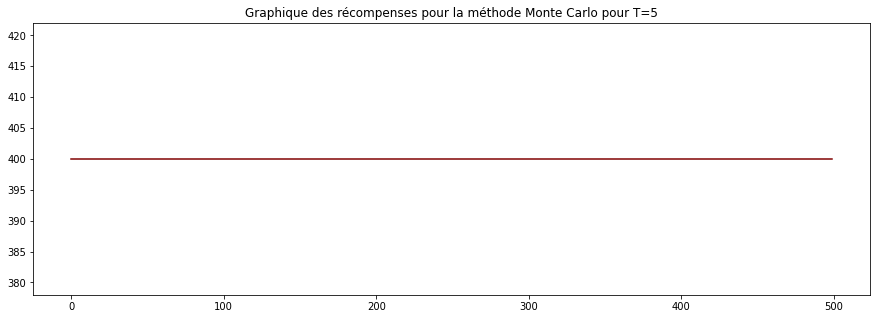

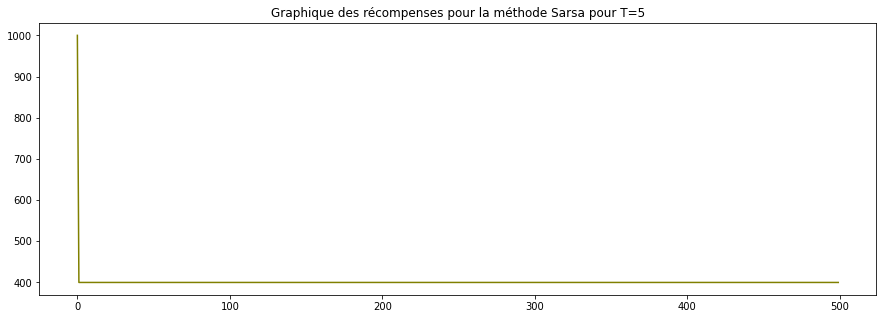

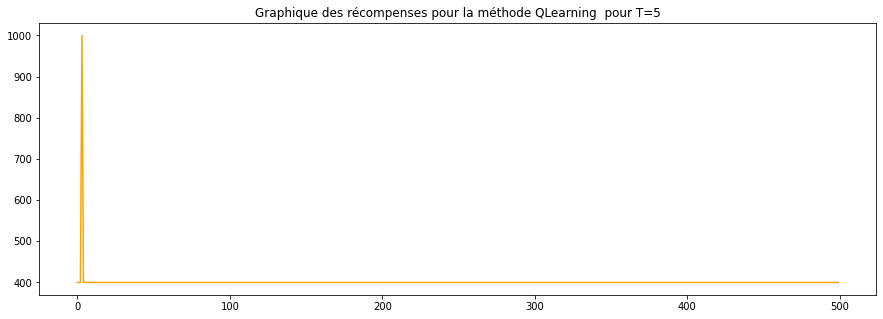

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("Graphique des récompenses pour la méthode Monte Carlo pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("Graphique des récompenses pour la méthode Sarsa pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("Graphique des récompenses pour la méthode QLearning  pour T=5")
plt.show()

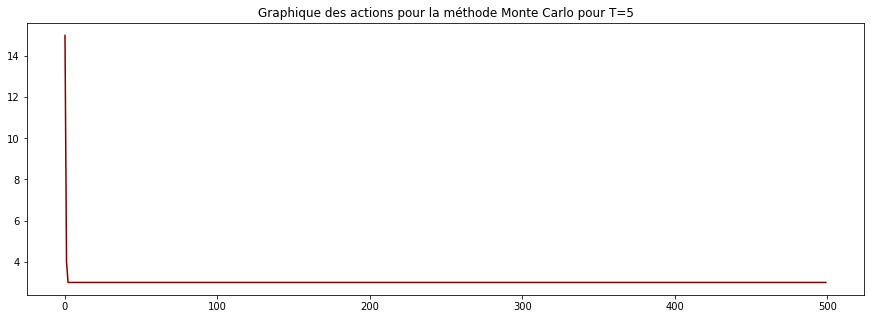

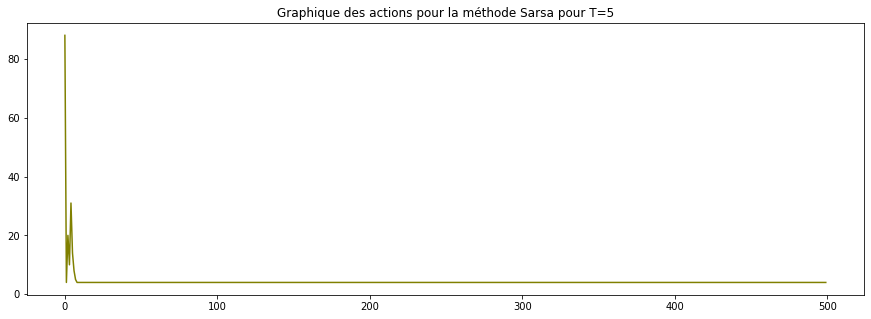

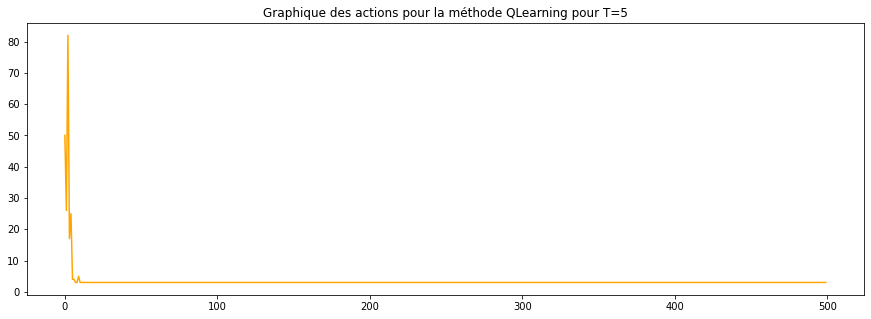

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour T=5")
plt.show()

##### **T=20**

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo_softmax(env, 0.5, 500, 20)
q_sarsa,recomp_sarsa,action_sarsa=sarsa_softmax(env, 0.9, 0.1, 500, 20)
q_qlearning,recomp_qlearning,action_qlearning=qlearning_softmax(env, 0.9, 0.1, 500, 20)

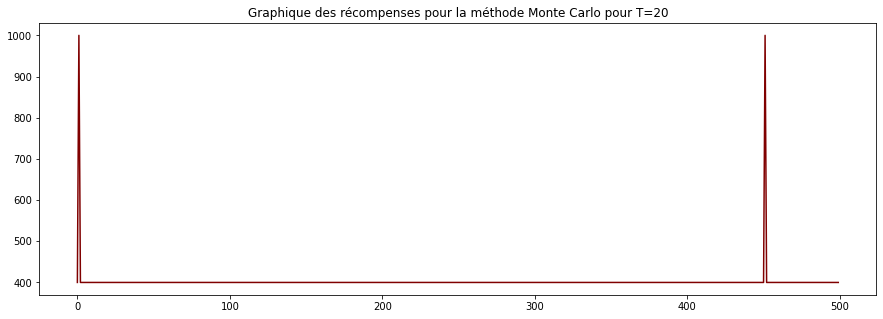

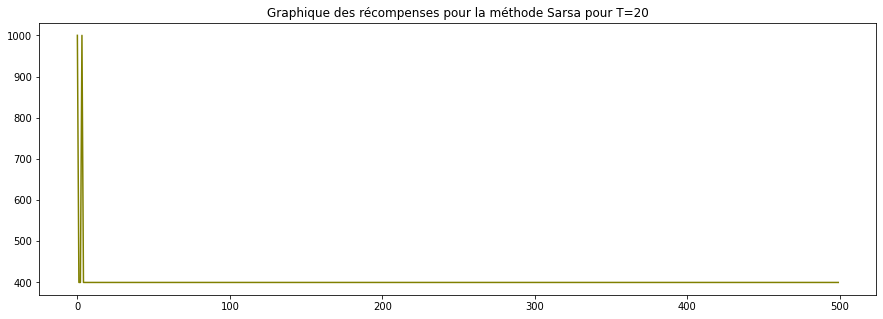

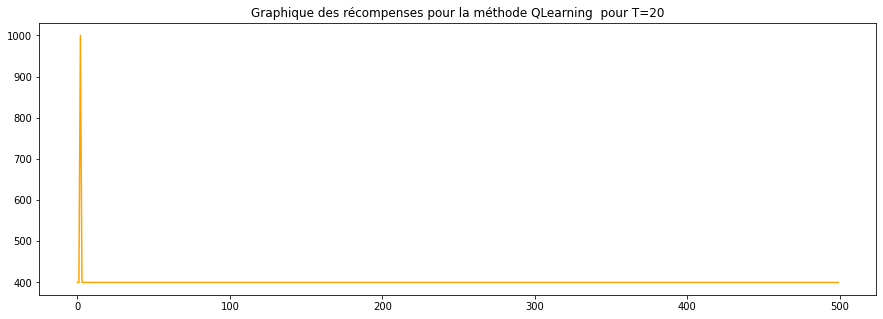

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("Graphique des récompenses pour la méthode Monte Carlo pour T=20")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("Graphique des récompenses pour la méthode Sarsa pour T=20")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("Graphique des récompenses pour la méthode QLearning  pour T=20")
plt.show()

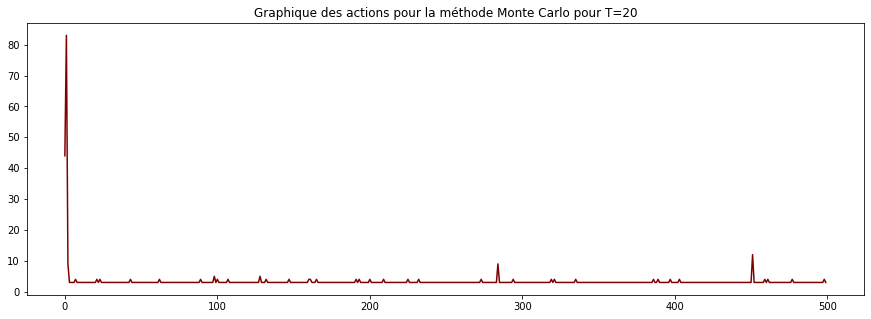

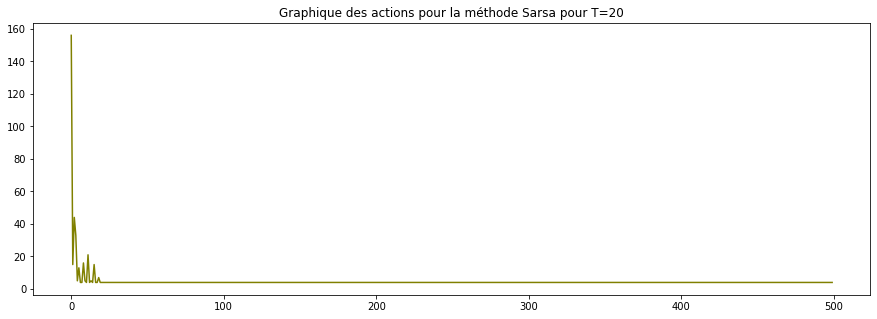

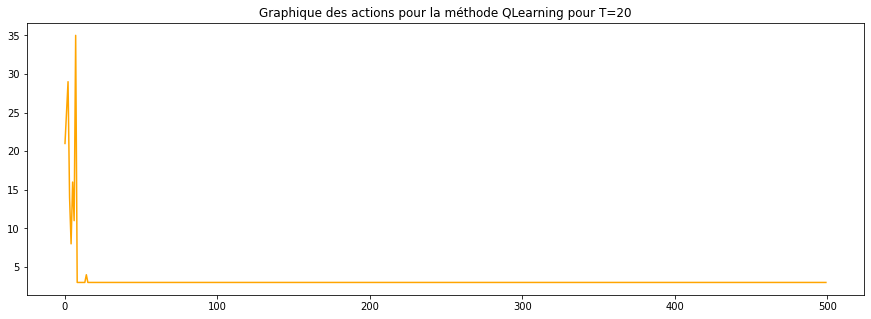

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour T=20")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour T=20")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour T=20")
plt.show()

##### **T=100**

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo_softmax(env, 0.5, 500, 100)
q_sarsa,recomp_sarsa,action_sarsa=sarsa_softmax(env, 0.9, 0.1, 500, 100)
q_qlearning,recomp_qlearning,action_qlearning=qlearning_softmax(env, 0.9, 0.1, 500, 100)

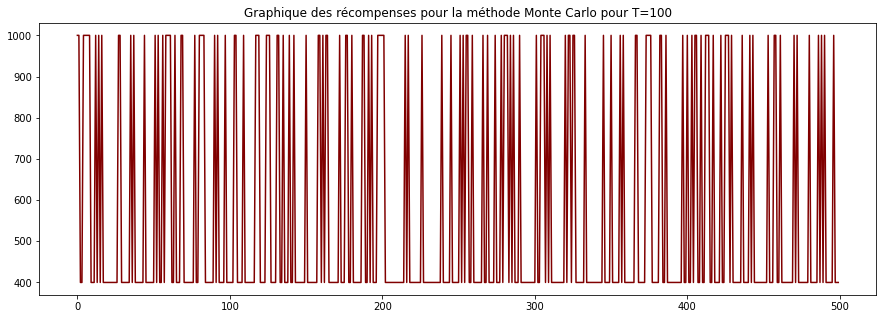

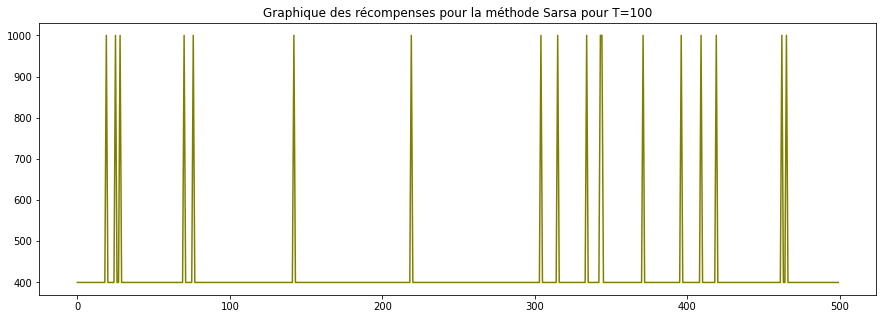

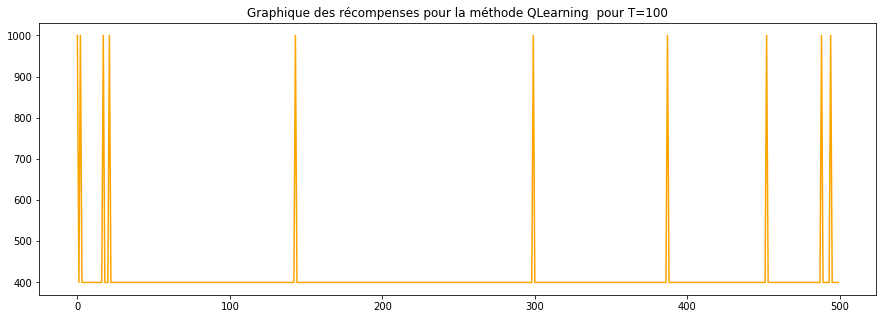

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("Graphique des récompenses pour la méthode Monte Carlo pour T=100")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("Graphique des récompenses pour la méthode Sarsa pour T=100")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("Graphique des récompenses pour la méthode QLearning  pour T=100")
plt.show()

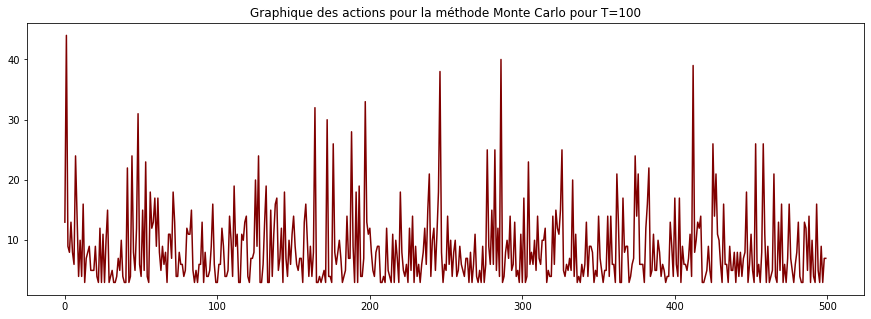

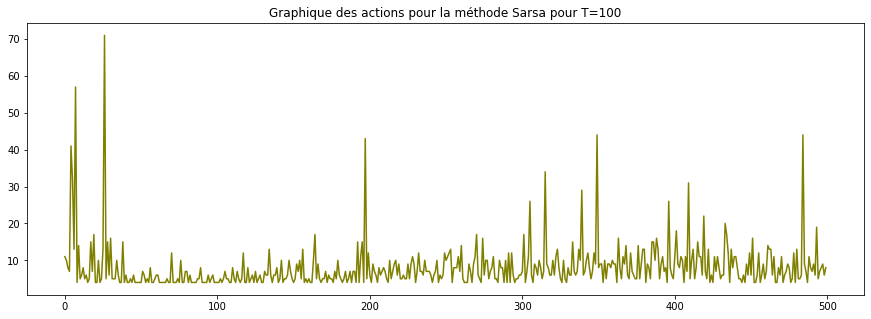

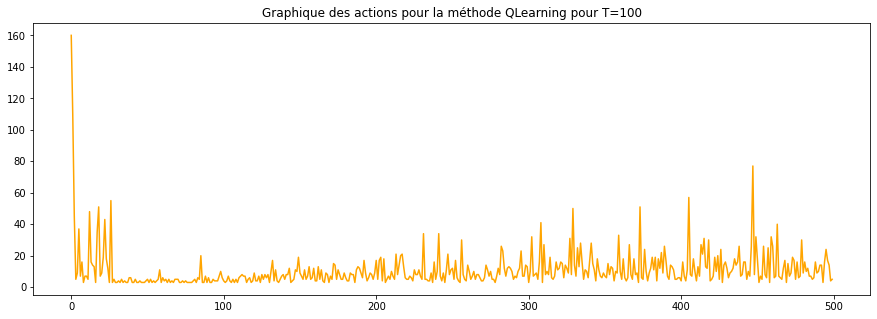

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour T=100")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour T=100")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour T=100")
plt.show()

##### **Remarques**

Nous remarquons que plus T est grand, plus nous explorons, et ce pour les differents algorithmes: Monte-Carlo, Sarsa et QLearning.  
En effet, les valeurs obtenus pour des T faibles dans la courbe des actions sont casiement nulles, contrairement aux grandes valeurs de T où nous observons plus d'oscillation.
  

   

Quant aux courbes des récompenses, elles sont plutôt similaires (valeurs fixes à 400 ou à 1000)  ou oscillent légérement entre ces deux valeurs, pour les différents épisodes et pour les differentes valeurs de températures T.  

#### **b. Exploration greedy avec une exploration optimiste**

In [ ]:
q_sarsa,recomp_sarsa,action_sarsa=sarsa_optimiste(env, 0.9, 0.1, 500)
q_qlearning,recomp_qlearning,action_qlearning=qlearning_optimiste(env, 0.9, 0.1, 500)

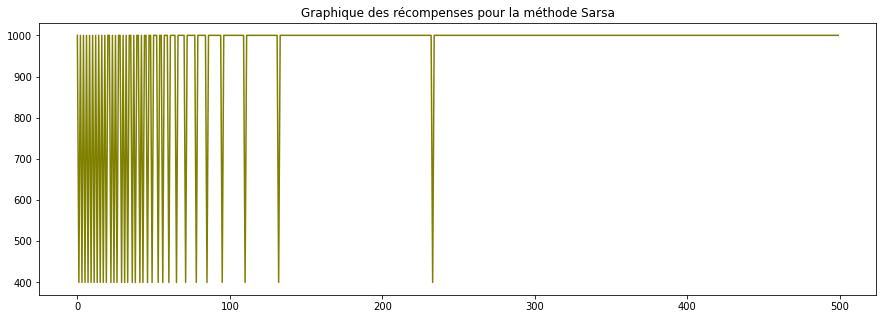

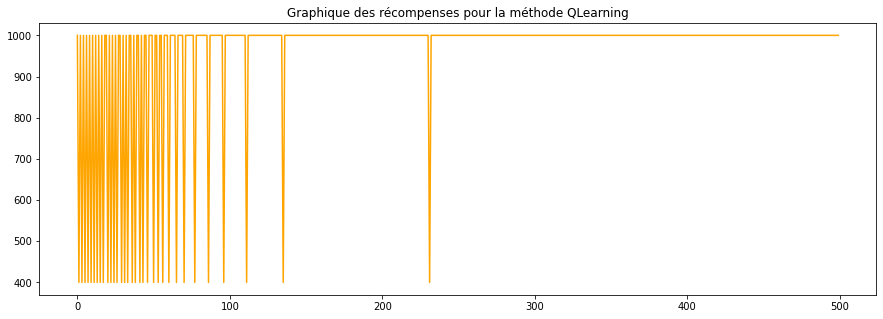

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("Graphique des récompenses pour la méthode Sarsa")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("Graphique des récompenses pour la méthode QLearning")
plt.show()

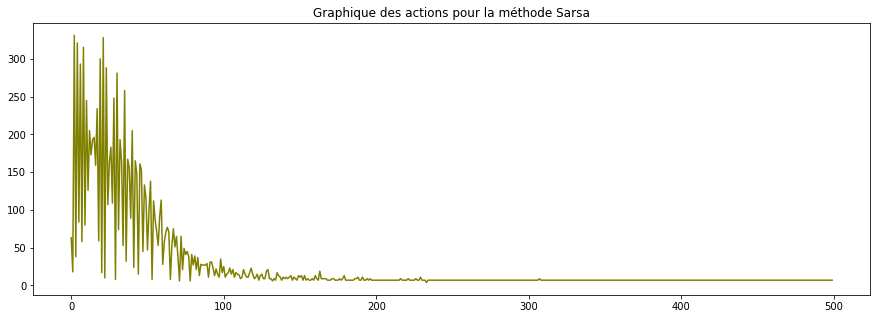

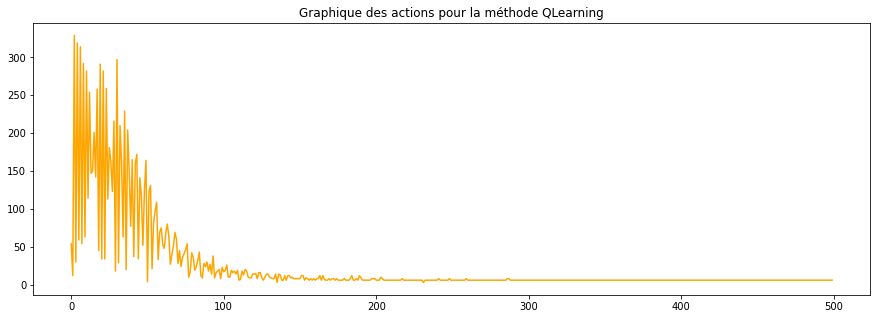

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning")
plt.show()

##### **Remarques**

Contrairement à ce qu'on a observé plus haut, la courbe des gains oscille énormement entre les 2 valeurs 400 et 1000.  
Quant à la courbe des actions, le nombre d'action baisse progressivement au fur et à mesure que le nombre d'épisodes augmente.

## **Question 3**

Dans cette partie, nous allons reproduire les tests précédents dans les environnements FrozenLake44 et FoorRooms_Key.

### **Environnement FrozenLake44**

In [ ]:
env=base.FrozenLake44()

#### **a. Exploration e-greedy**

##### **T=5 et différentes valeurs de $\epsilon$**

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 0.5, 5)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500,0.5, 5)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500,0.5, 5)

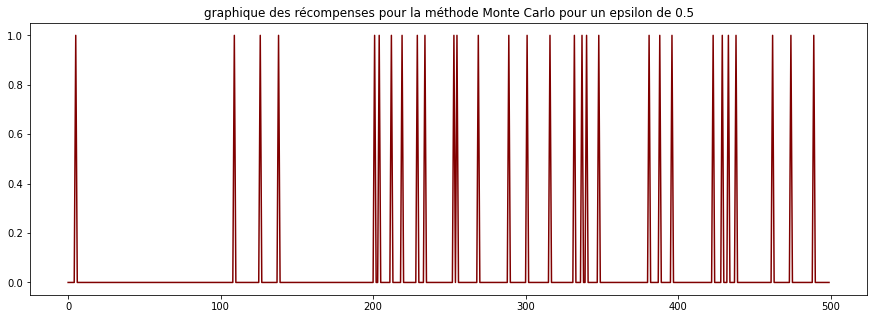

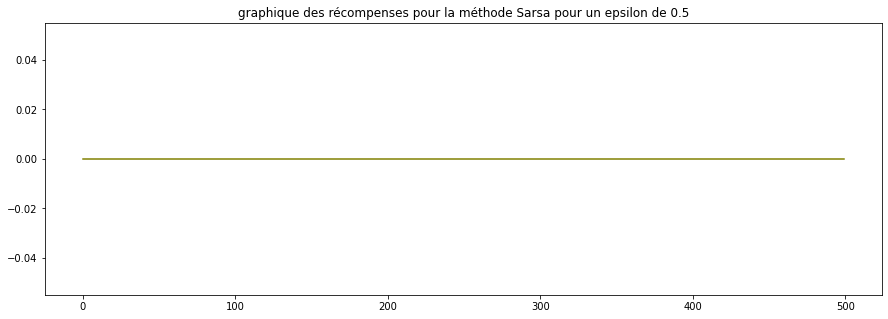

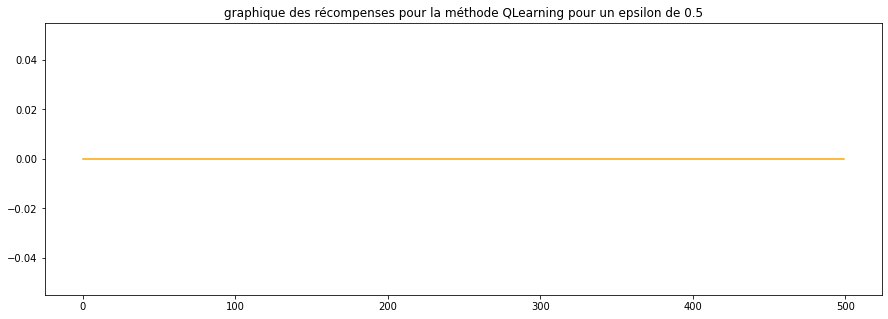

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 0.5")
plt.show()

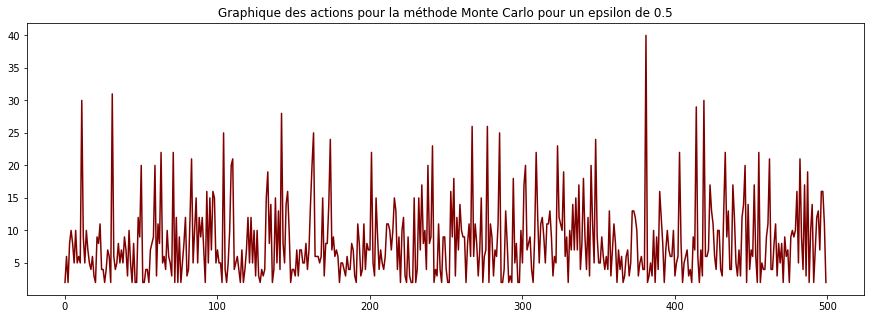

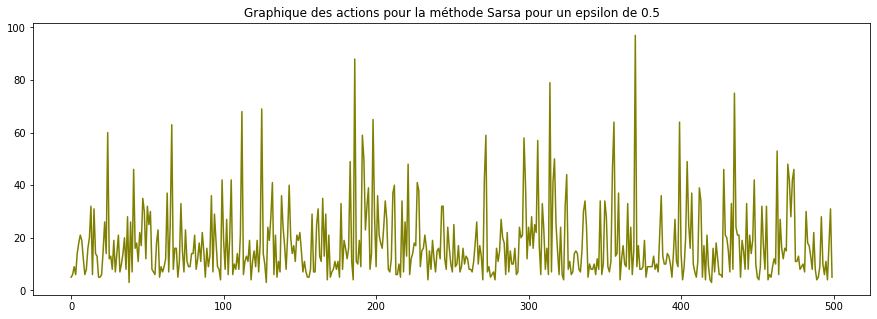

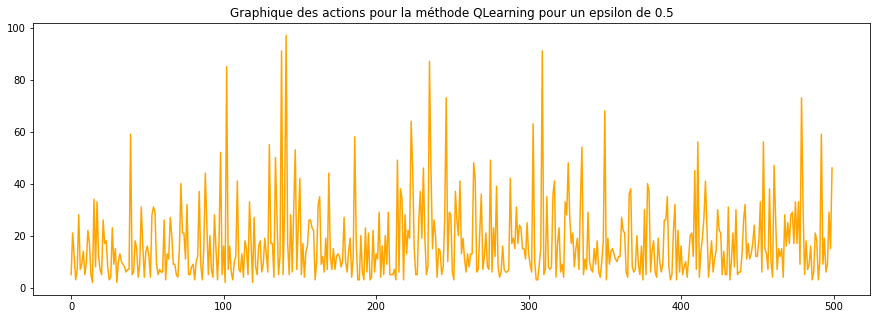

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 0.5")
plt.show()

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 0.1, 5)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500, 0.1, 5)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500, 0.1, 5)

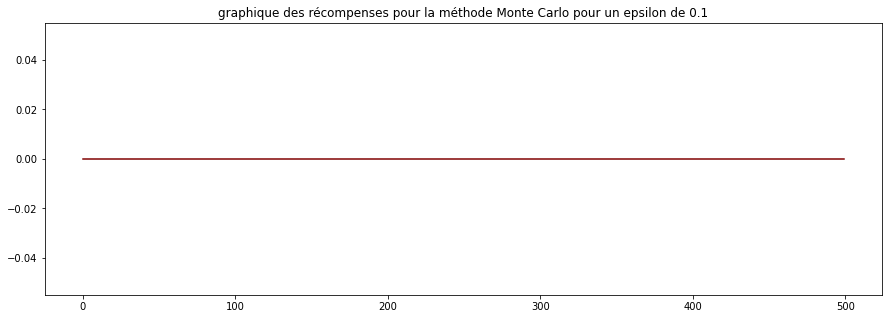

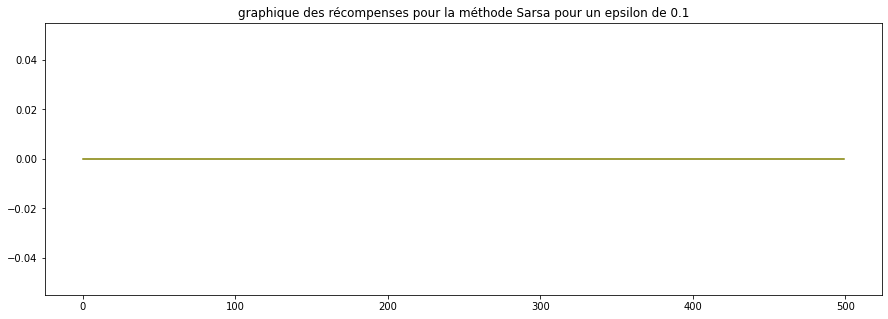

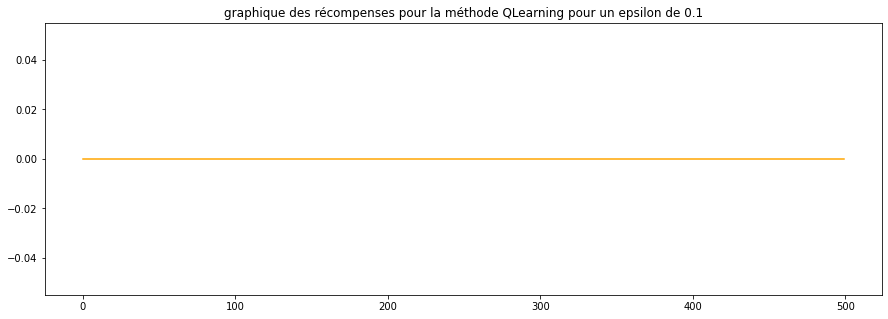

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 0.1")
plt.show()

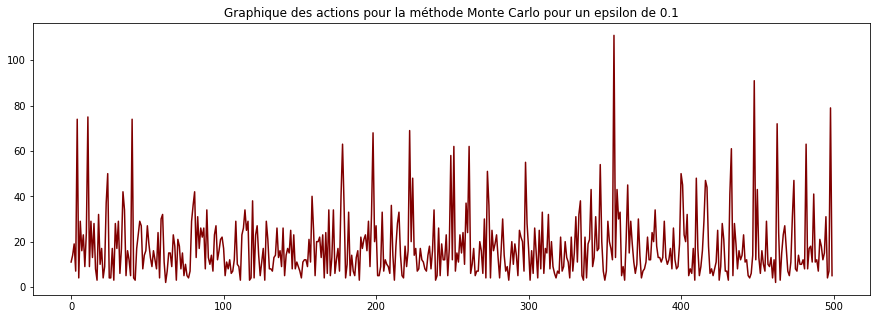

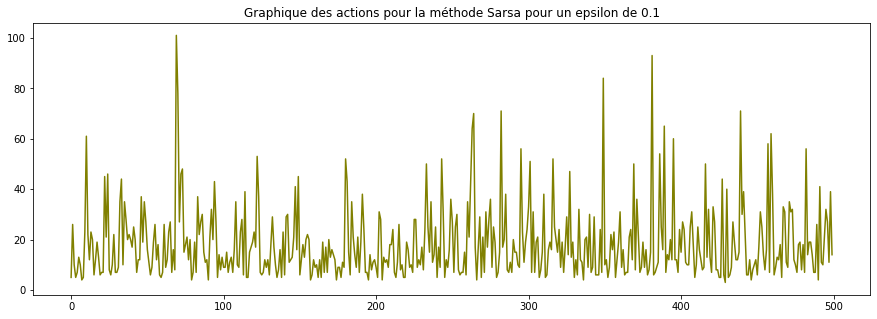

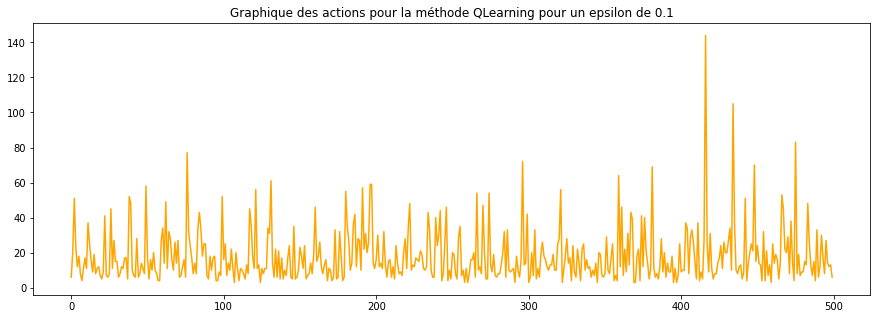

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 0.1")
plt.show()

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 1, 5)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500,1, 5)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500,1, 5)

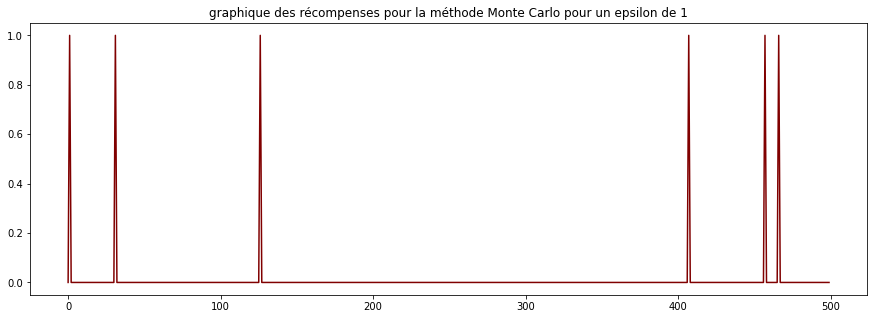

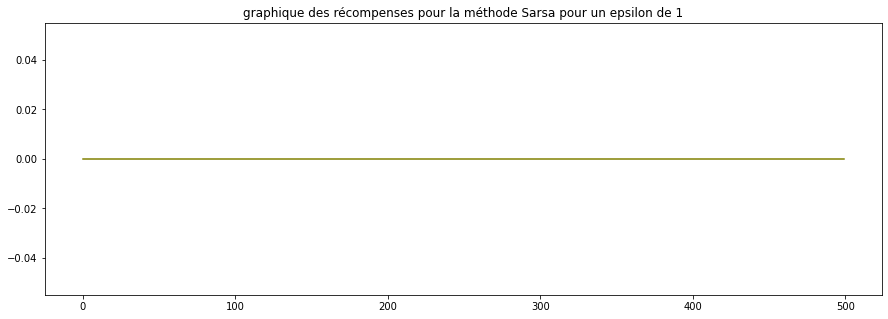

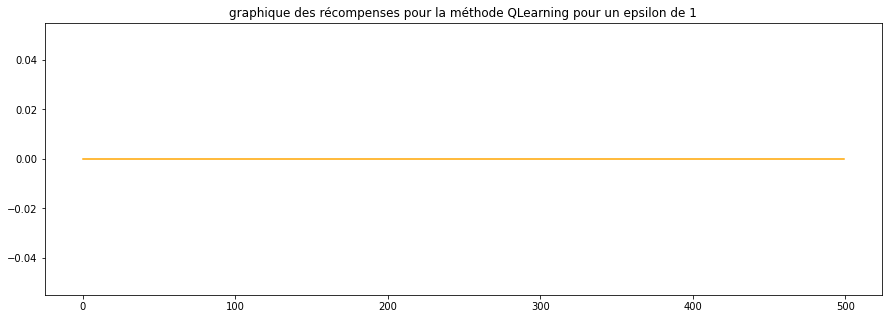

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 1")
plt.show()

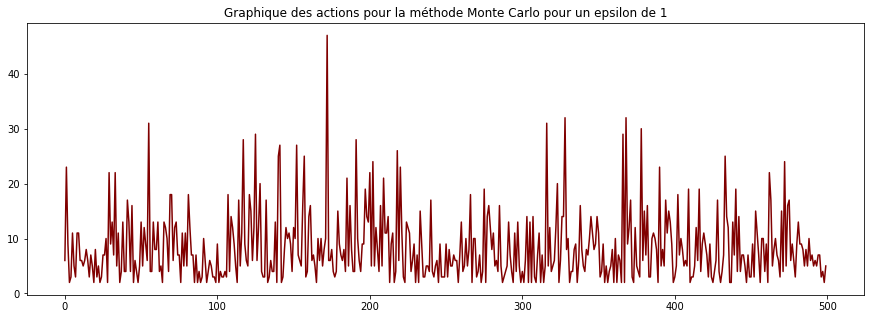

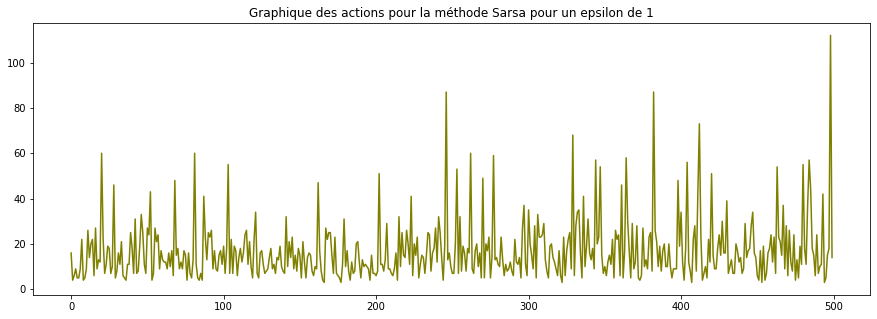

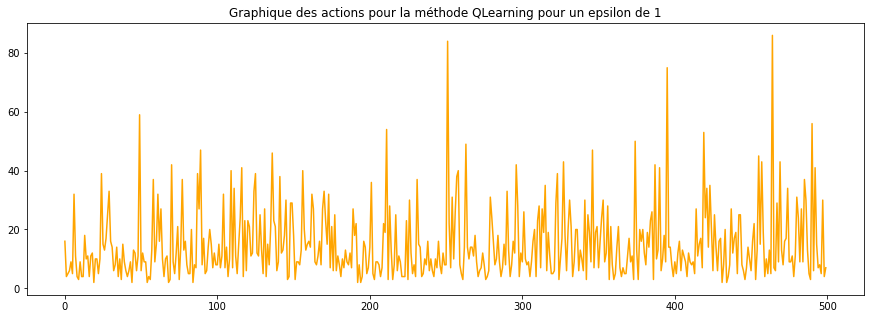

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 1")
plt.show()

##### **T=200 et différentes valeurs de $\epsilon$**

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 0.5, 200)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500,0.5, 200)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500,0.5, 200)

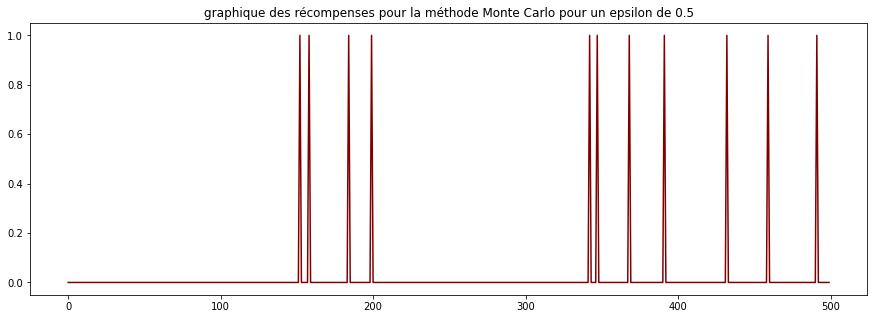

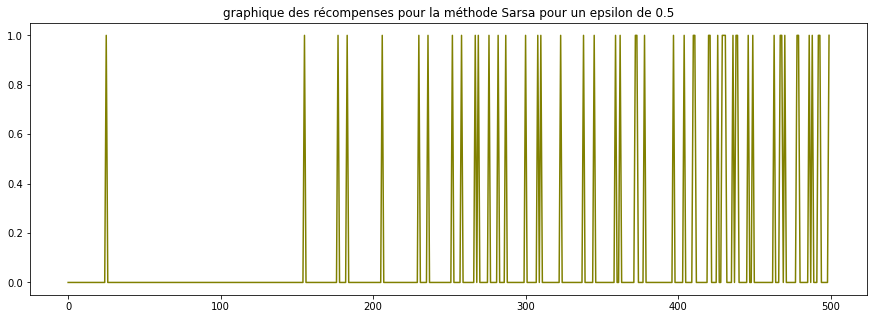

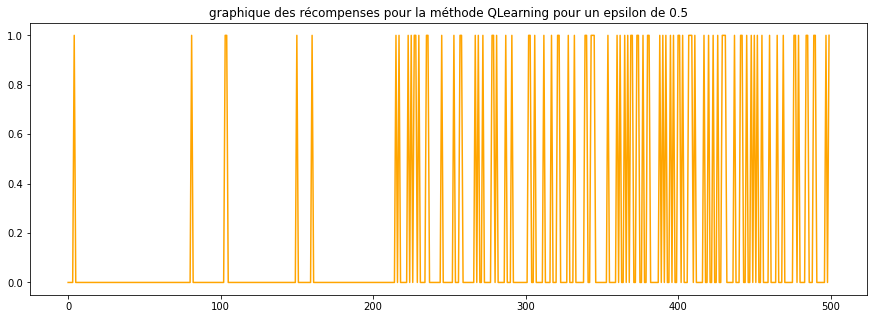

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 0.5")
plt.show()

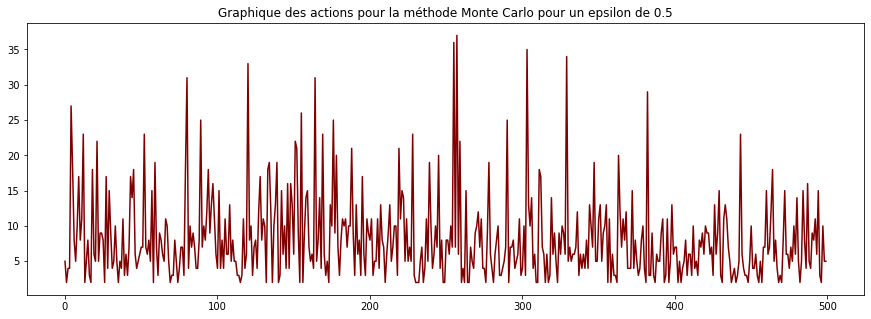

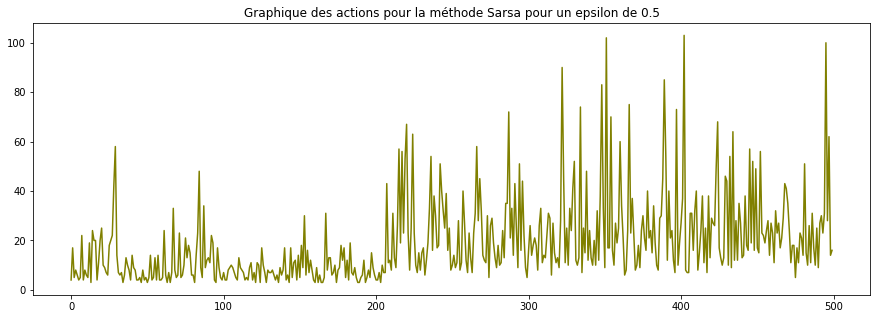

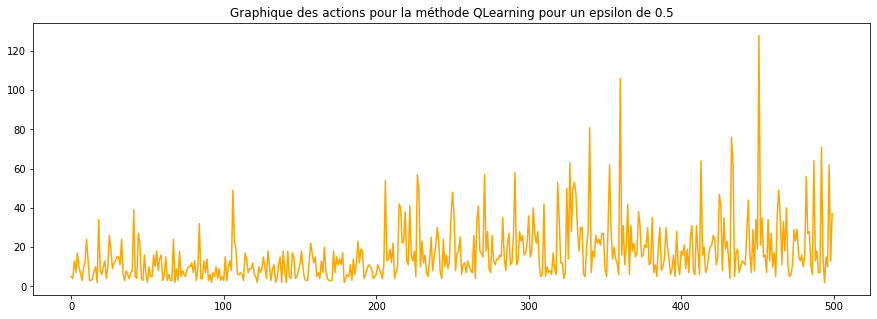

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 0.5")
plt.show()

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 0.1, 200)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500, 0.1, 200)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500, 0.1, 200)

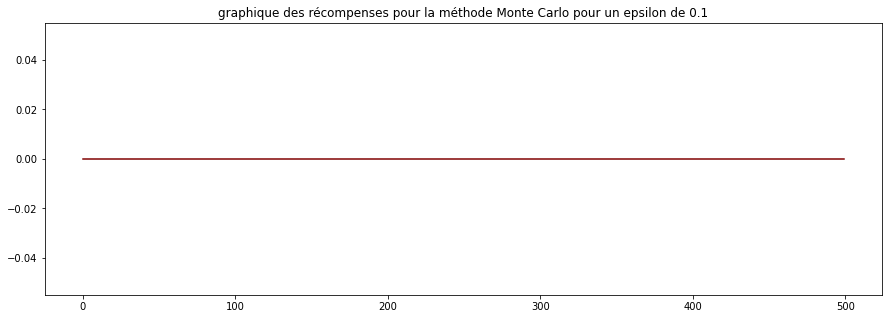

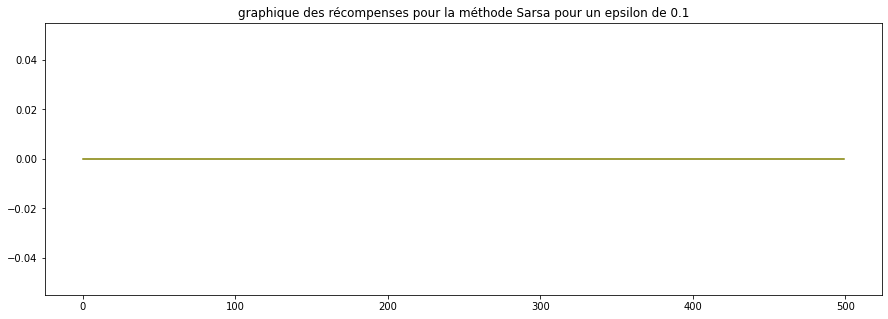

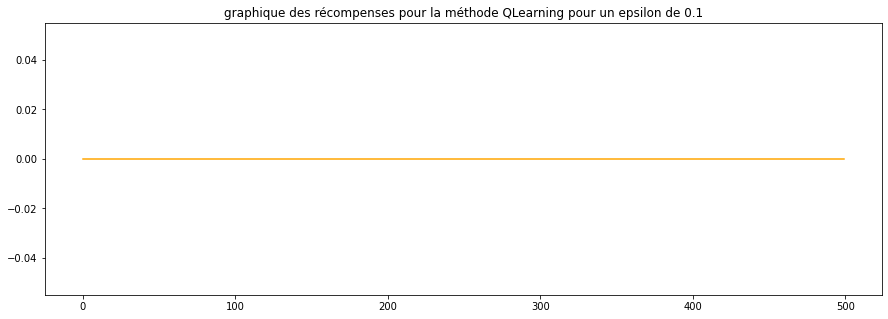

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 0.1")
plt.show()

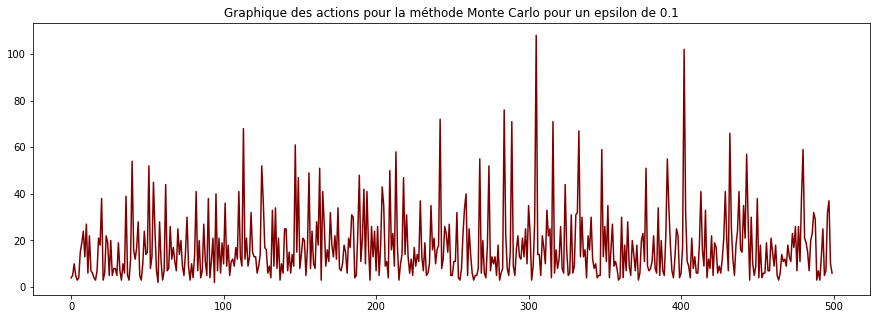

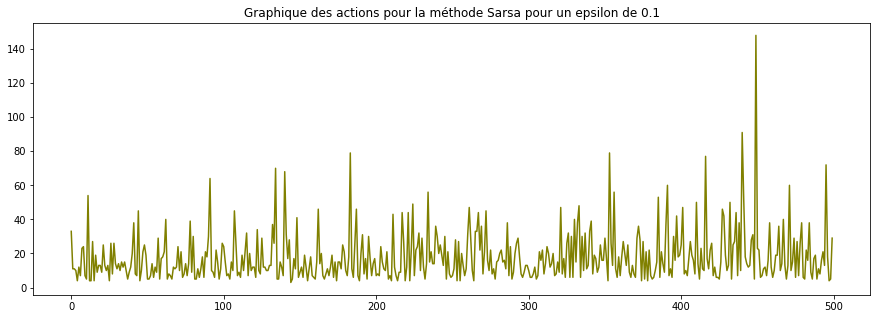

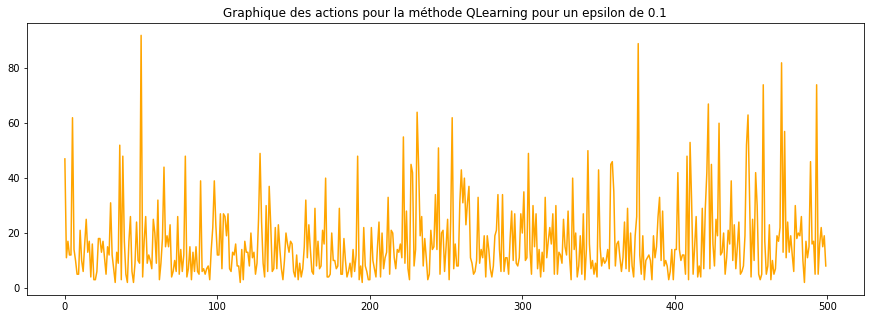

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 0.1")
plt.show()

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 1, 5)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500,1, 5)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500,1, 5)

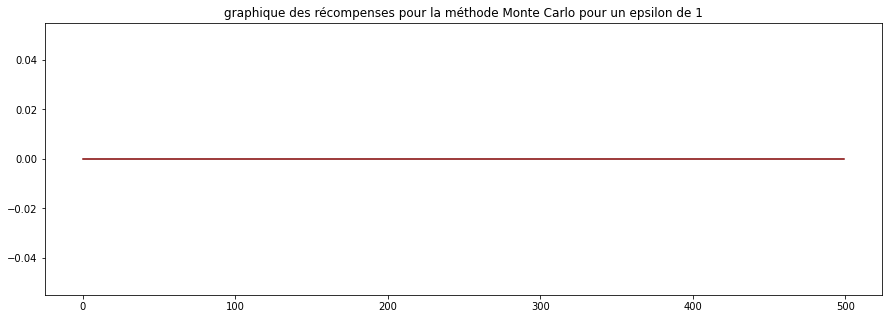

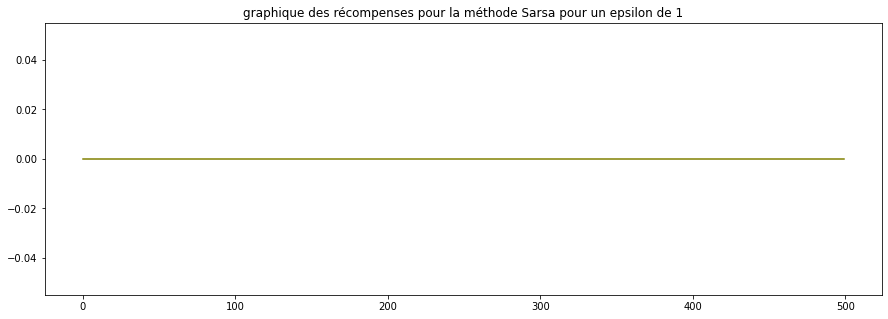

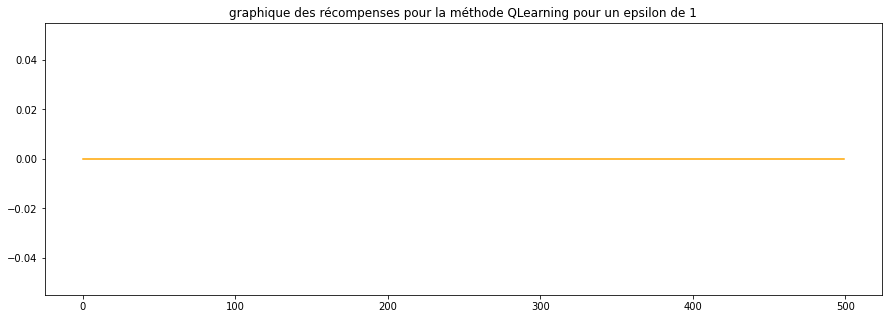

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 1")
plt.show()

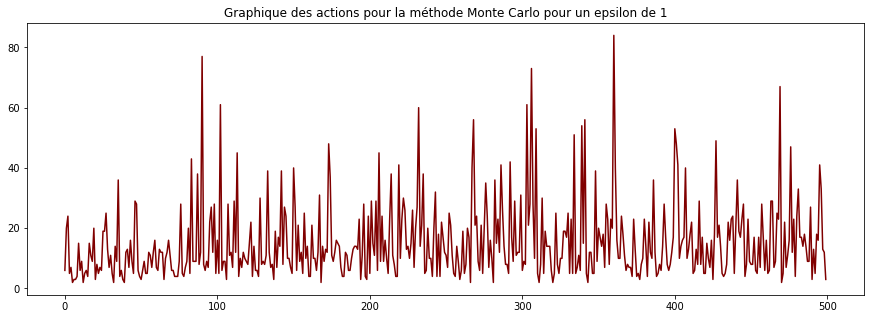

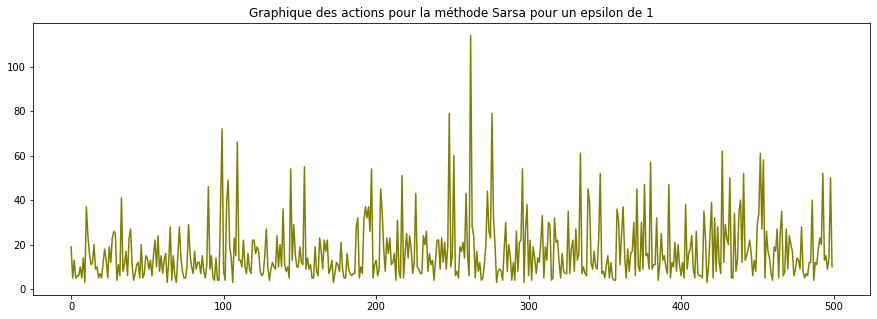

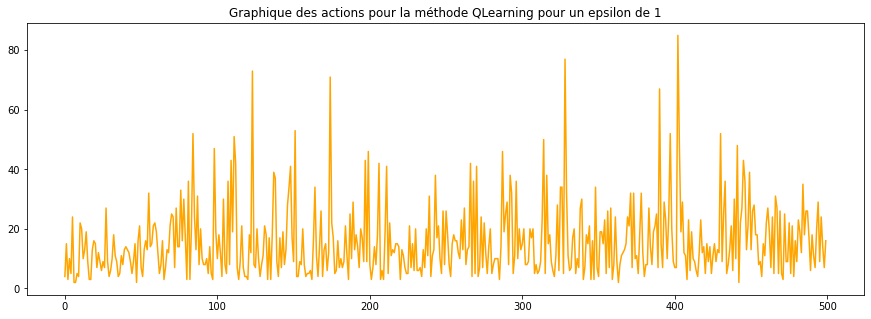

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 1")
plt.show()

##### **T=400 et différentes valeurs de $\epsilon$**

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 0.5, 400)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500,0.5, 400)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500,0.5, 400)

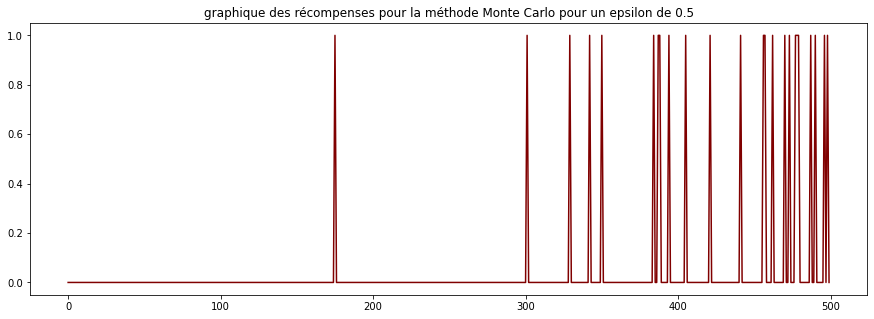

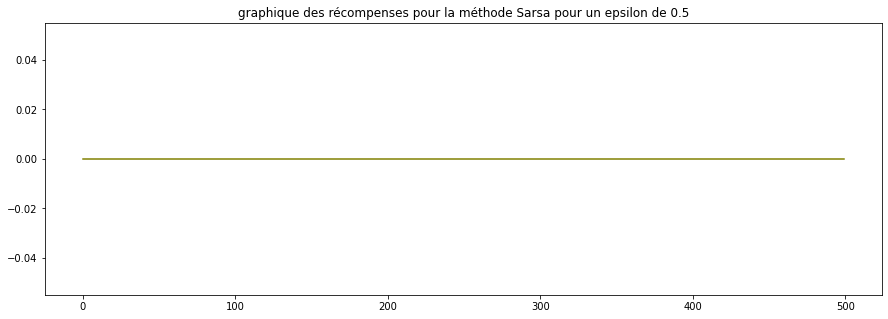

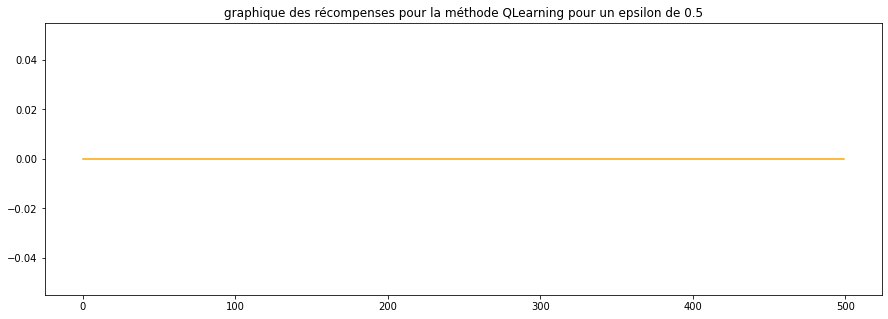

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 0.5")
plt.show()

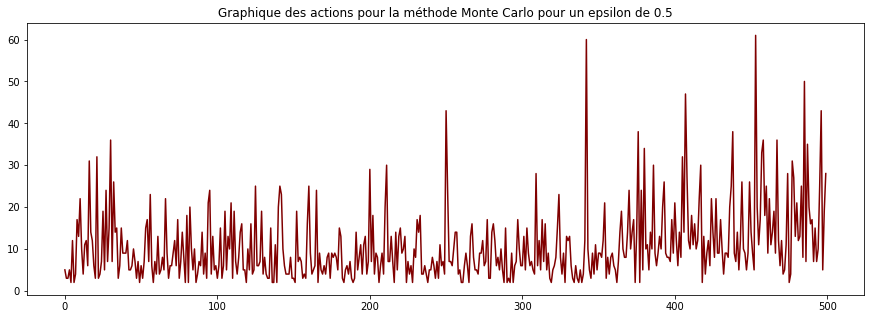

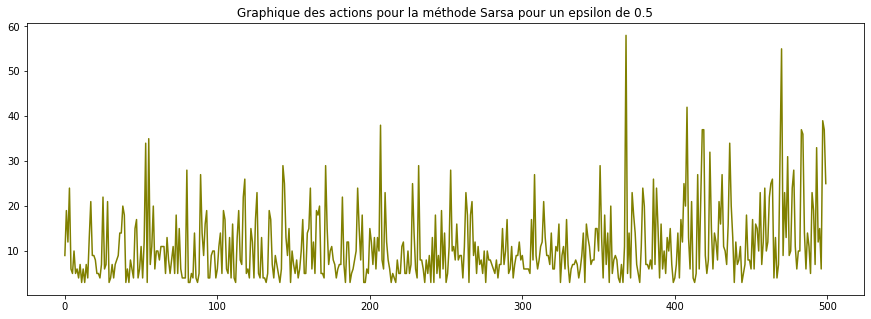

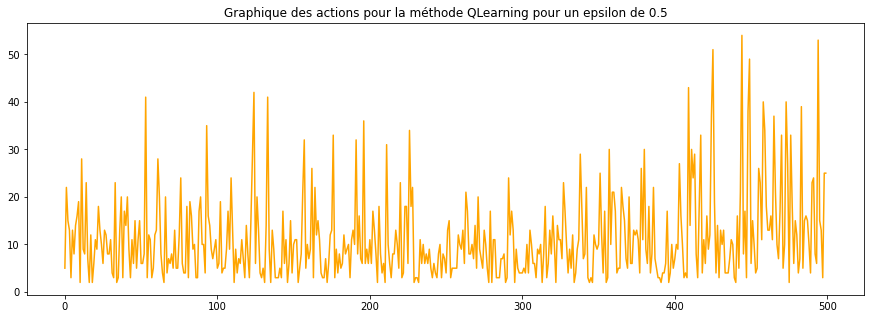

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 0.5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 0.5")
plt.show()

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 0.1, 400)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500, 0.1, 400)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500, 0.1, 400)

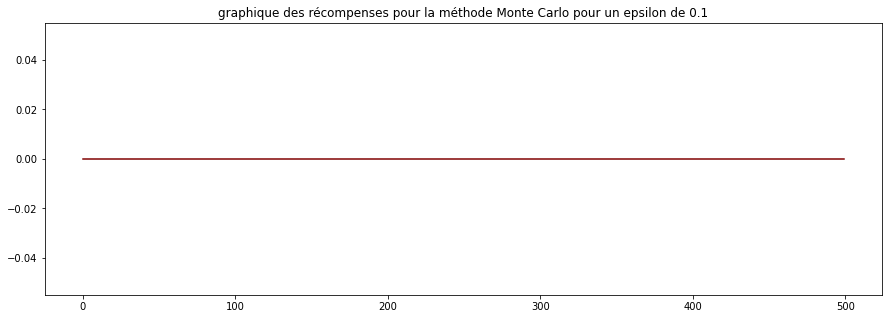

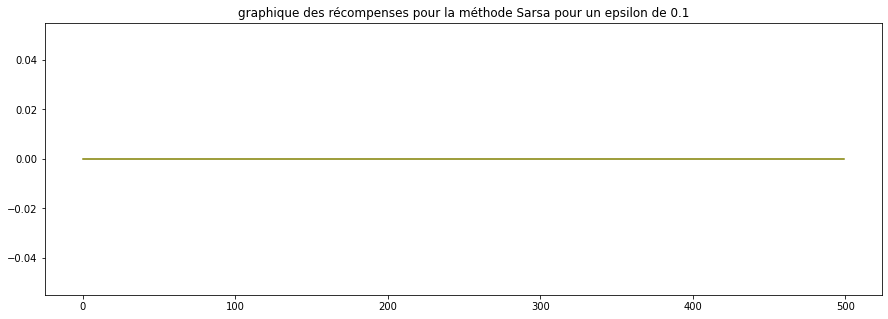

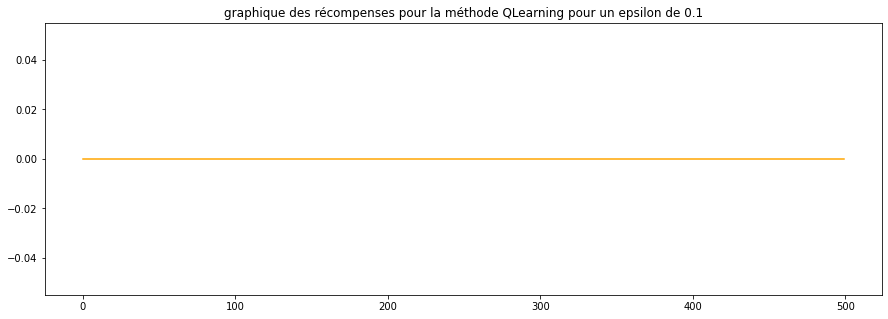

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 0.1")
plt.show()

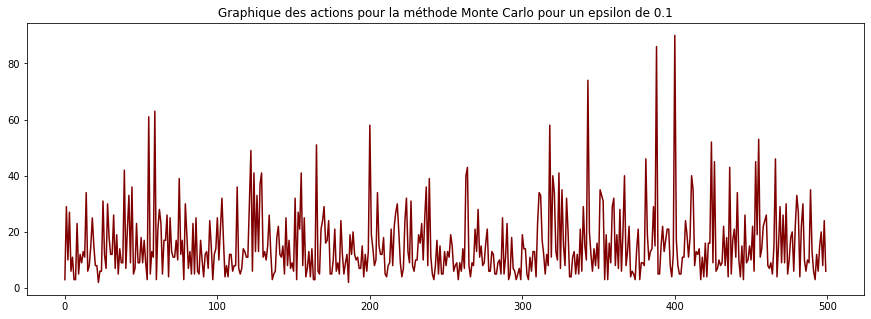

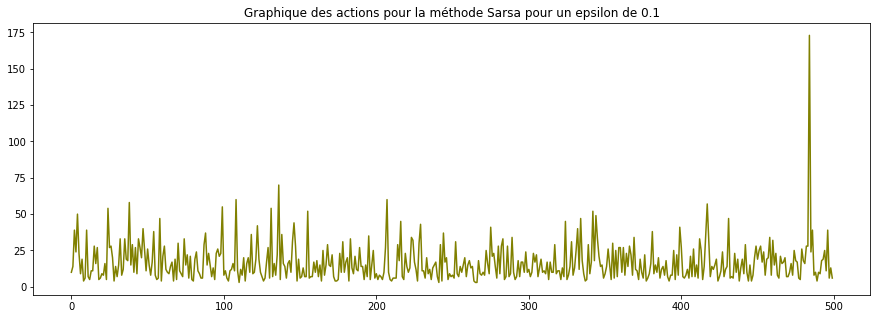

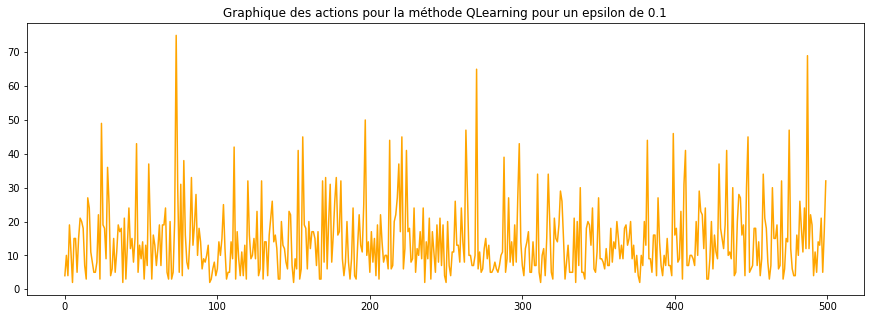

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 0.1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 0.1")
plt.show()

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 500, 1, 5)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 500,1, 5)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 500,1, 5)

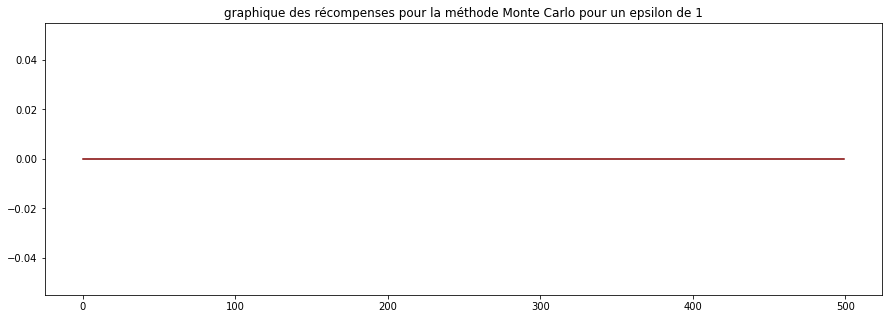

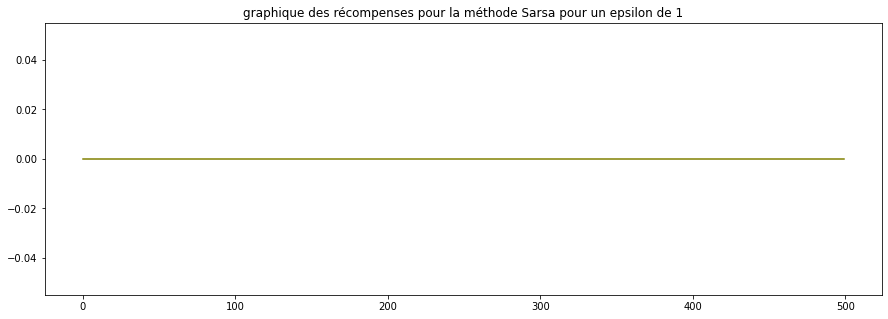

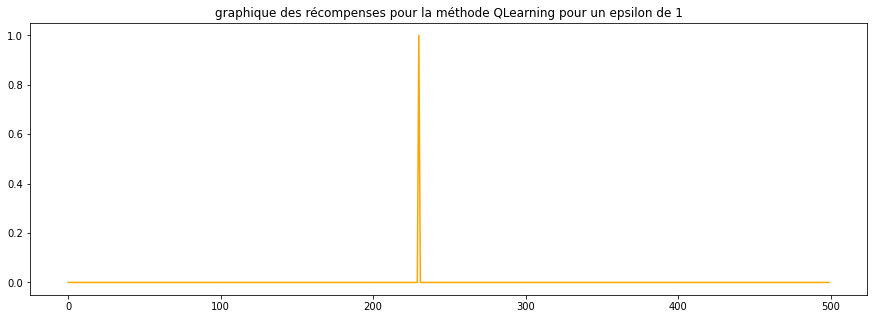

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 1")
plt.show()

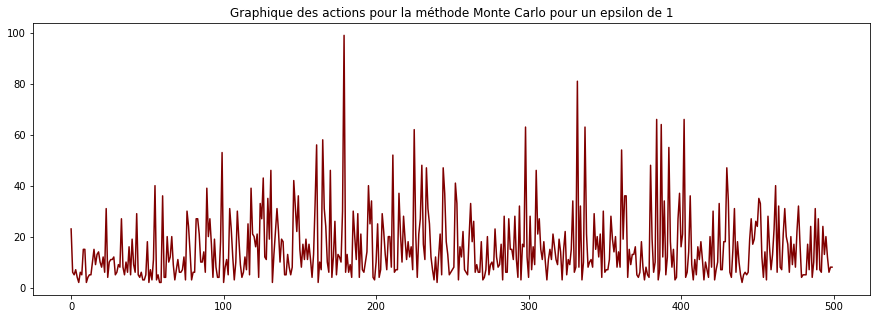

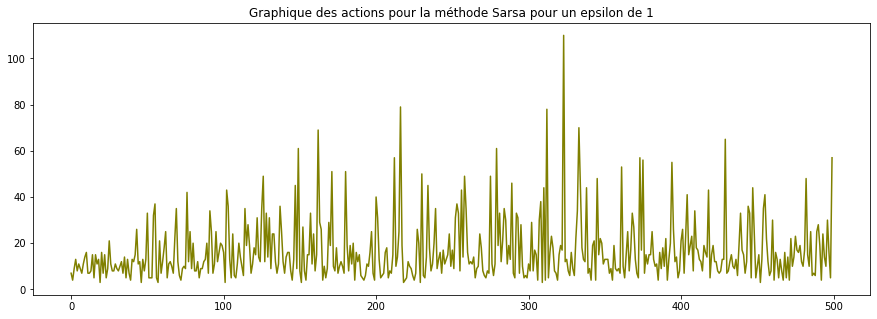

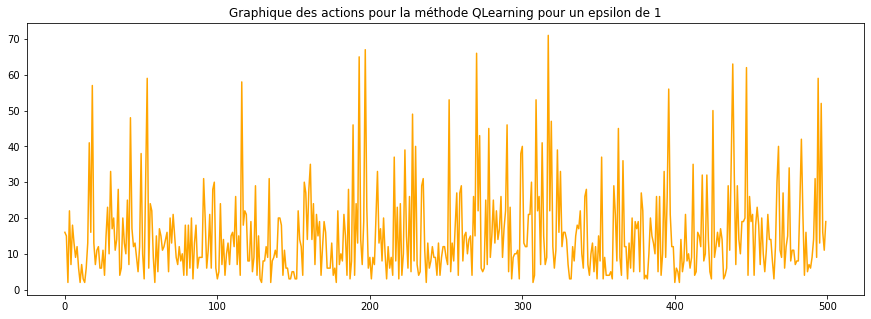

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 1")
plt.show()

##### **Remarques** 

  Pour les differents T et pour les différentes valeurs d'$\epsilon$ les courbes sont plutôt similaires pour les 3 algorithmes: Monte-Carlo, Sarsa, QLearning.  
La courbe des actions oscille entre 0 et 100, quant à la courbe des gains elle est putôt fixe à une valeur (0 ou 1). 


#### **b. Exploration softmax**

##### **T=5**

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo_softmax(env, 0.5, 500, 5)
q_sarsa,recomp_sarsa,action_sarsa=sarsa_softmax(env, 0.9, 0.1, 500, 5)
q_qlearning,recomp_qlearning,action_qlearning=qlearning_softmax(env, 0.9, 0.1, 500, 5)

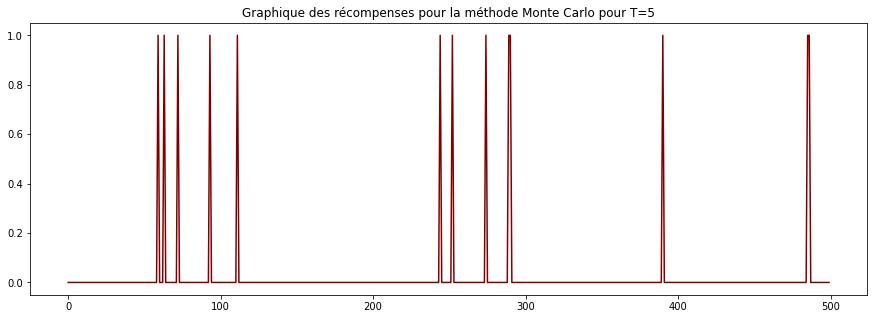

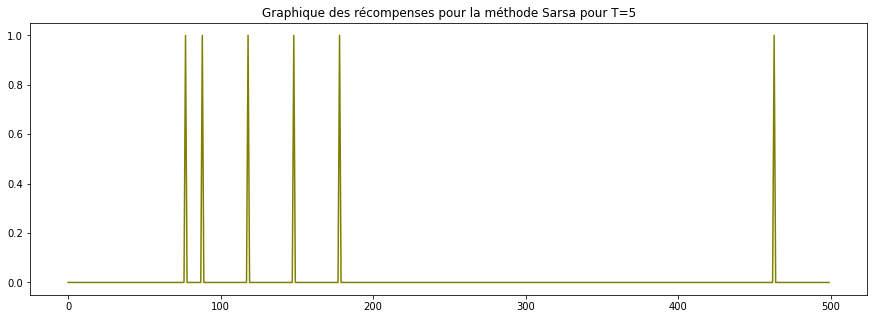

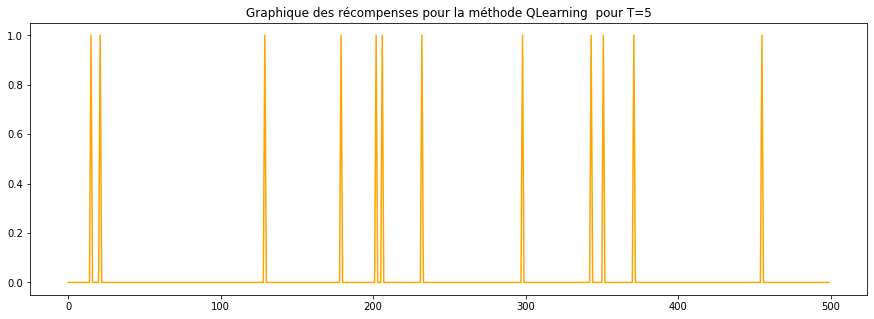

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("Graphique des récompenses pour la méthode Monte Carlo pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("Graphique des récompenses pour la méthode Sarsa pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("Graphique des récompenses pour la méthode QLearning  pour T=5")
plt.show()

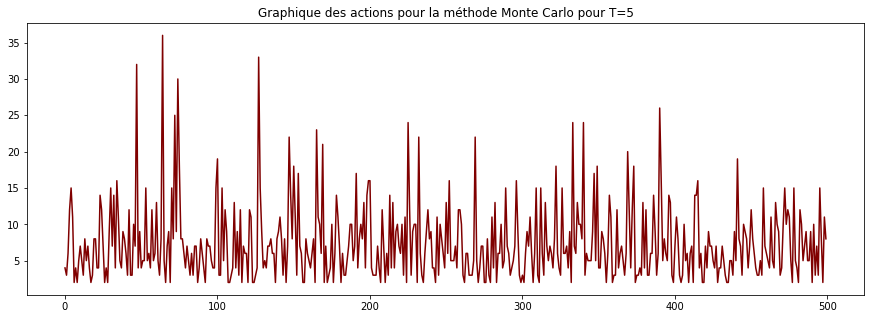

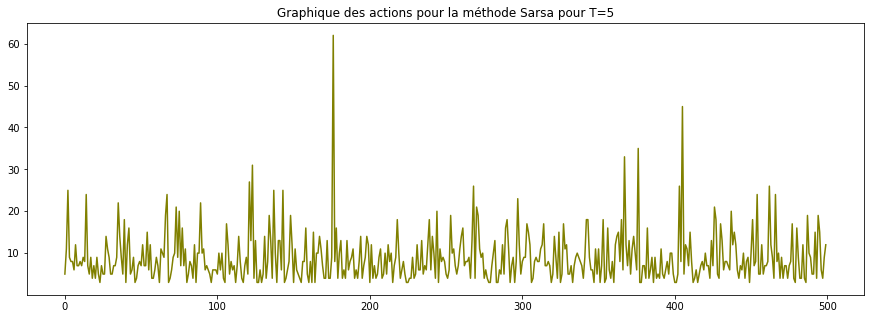

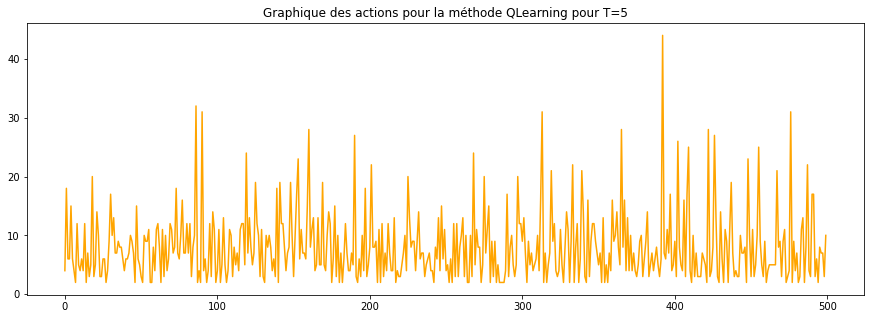

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour T=5")
plt.show()

##### **T=20**

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo_softmax(env, 0.5, 500, 20)
q_sarsa,recomp_sarsa,action_sarsa=sarsa_softmax(env, 0.9, 0.1, 500, 20)
q_qlearning,recomp_qlearning,action_qlearning=qlearning_softmax(env, 0.9, 0.1, 500, 20)

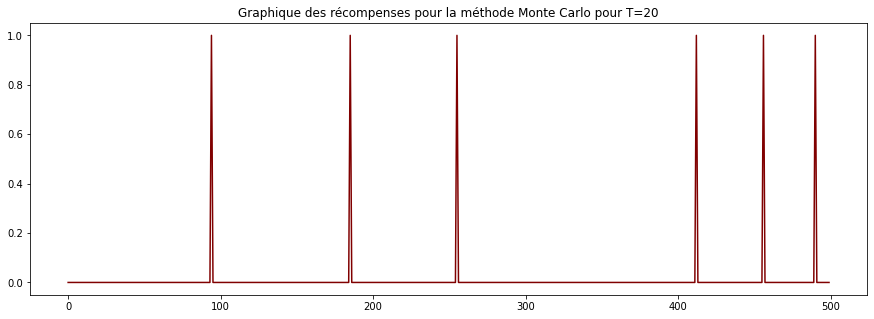

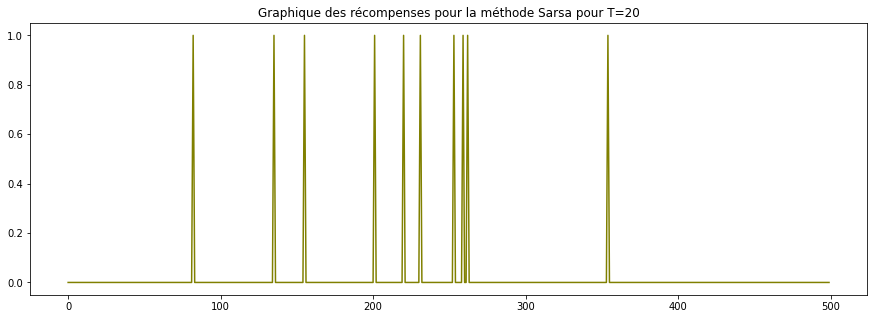

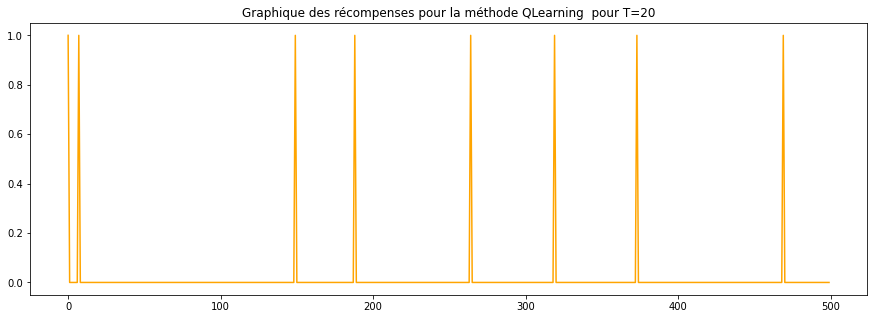

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("Graphique des récompenses pour la méthode Monte Carlo pour T=20")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("Graphique des récompenses pour la méthode Sarsa pour T=20")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("Graphique des récompenses pour la méthode QLearning  pour T=20")
plt.show()

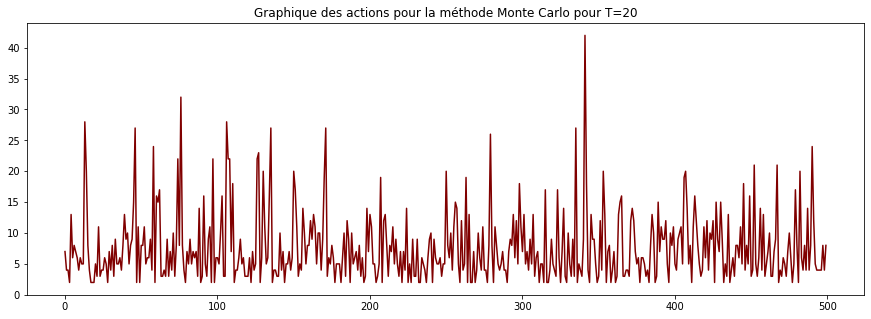

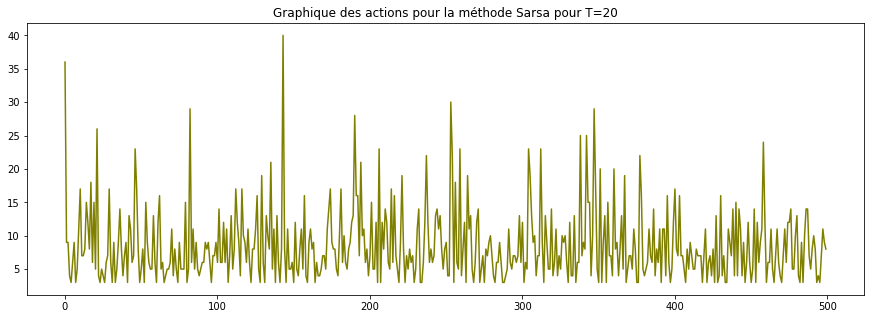

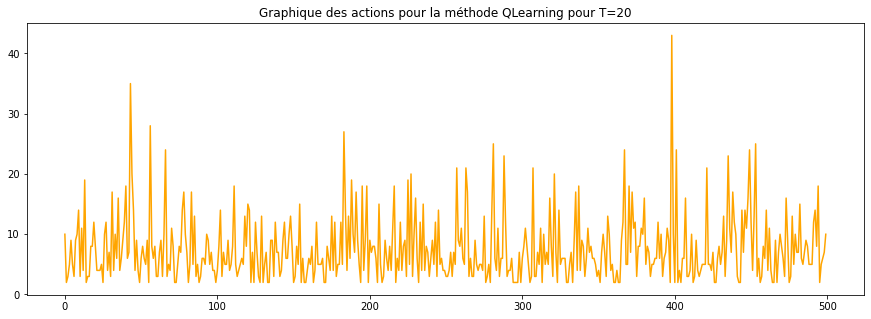

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour T=20")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour T=20")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour T=20")
plt.show()

##### **T=100**

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo_softmax(env, 0.5, 500, 100)
q_sarsa,recomp_sarsa,action_sarsa=sarsa_softmax(env, 0.9, 0.1, 500, 100)
q_qlearning,recomp_qlearning,action_qlearning=qlearning_softmax(env, 0.9, 0.1, 500, 100)

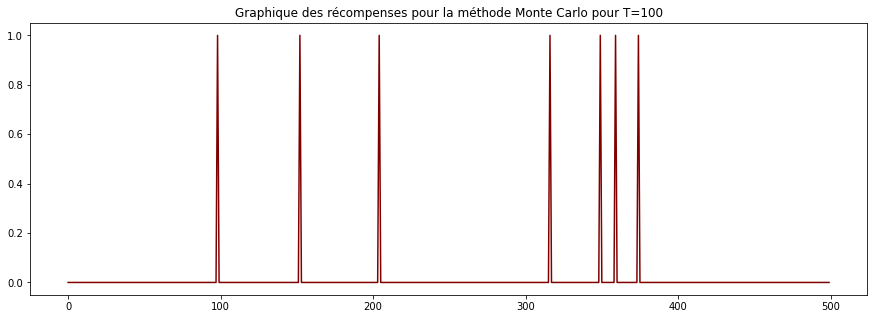

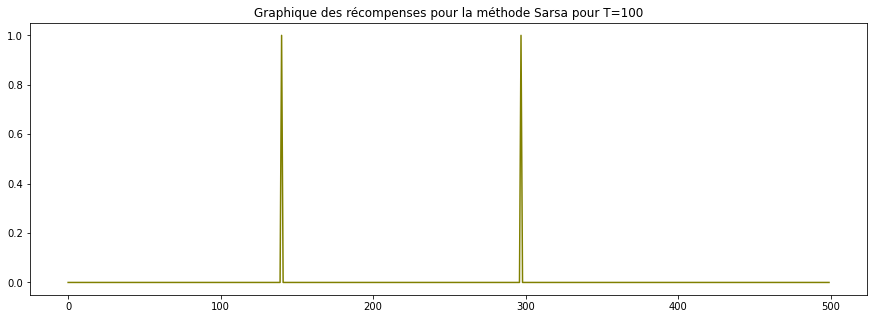

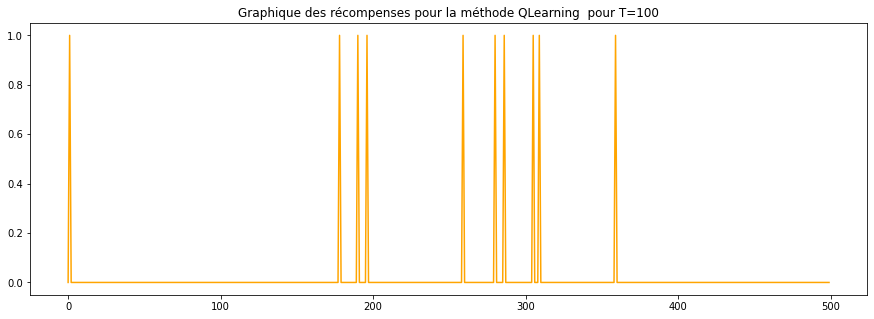

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("Graphique des récompenses pour la méthode Monte Carlo pour T=100")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("Graphique des récompenses pour la méthode Sarsa pour T=100")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("Graphique des récompenses pour la méthode QLearning  pour T=100")
plt.show()

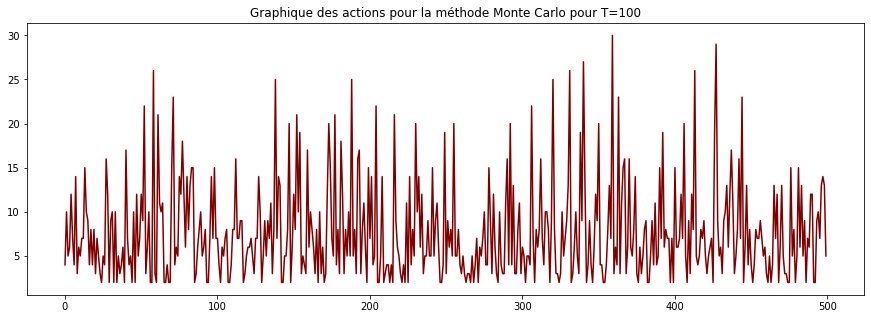

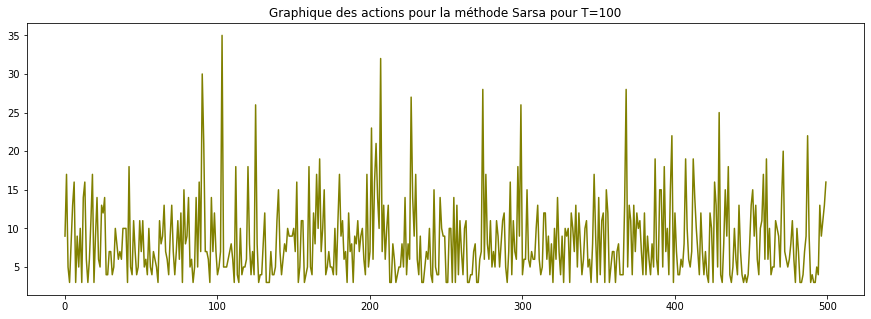

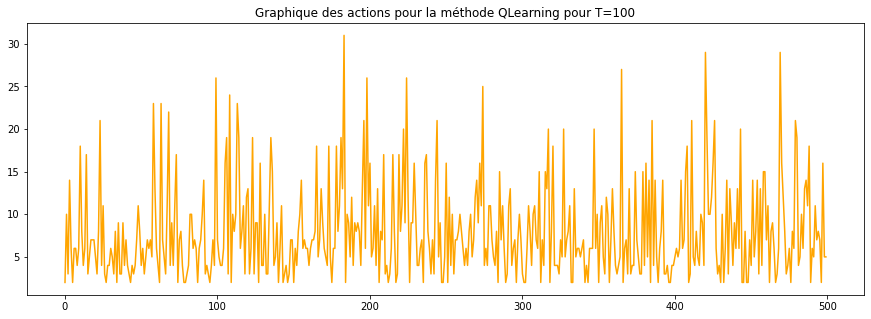

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour T=100")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour T=100")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour T=100")
plt.show()

##### **Remarques**

Pour les differents T et pour les différentes valeurs d'$\epsilon$ les courbes sont plutôt similaires pour les 3 algorithmes: Monte-Carlo, Sarsa, QLearning.  
La courbe des actions oscille entre 0 et 80, quant à la courbe des gains elle est putôt fixe à une valeur (0 ou 1). 

#### **c. Exploration greedy avec une exploration optimiste**

In [ ]:
q_sarsa,recomp_sarsa,action_sarsa=sarsa_optimiste(env, 0.9, 0.1, 500)
q_qlearning,recomp_qlearning,action_qlearning=qlearning_optimiste(env, 0.9, 0.1, 500)

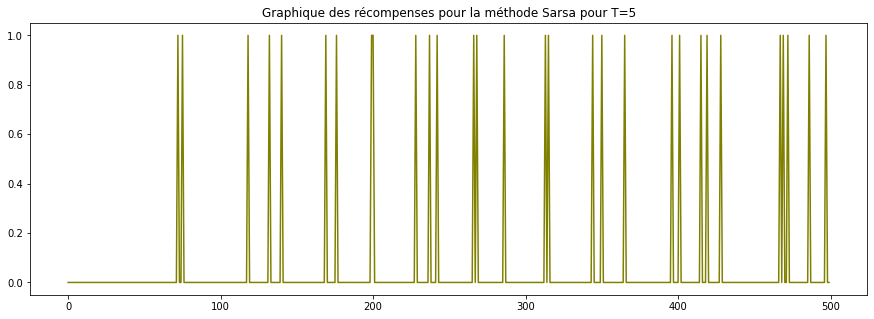

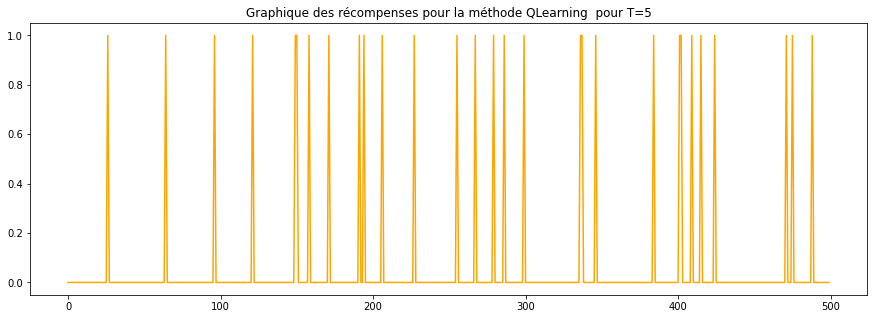

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("Graphique des récompenses pour la méthode Sarsa pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("Graphique des récompenses pour la méthode QLearning  pour T=5")
plt.show()

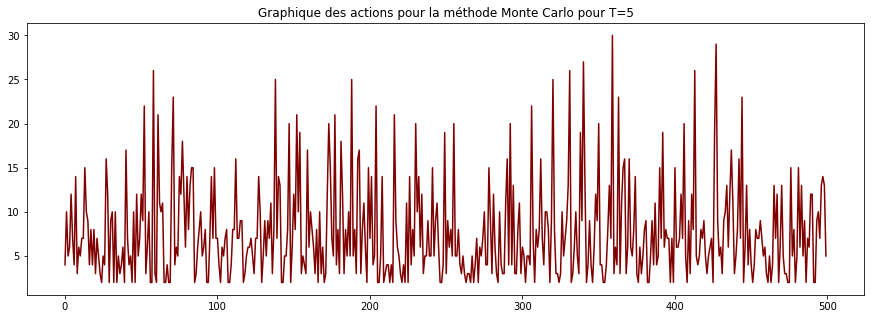

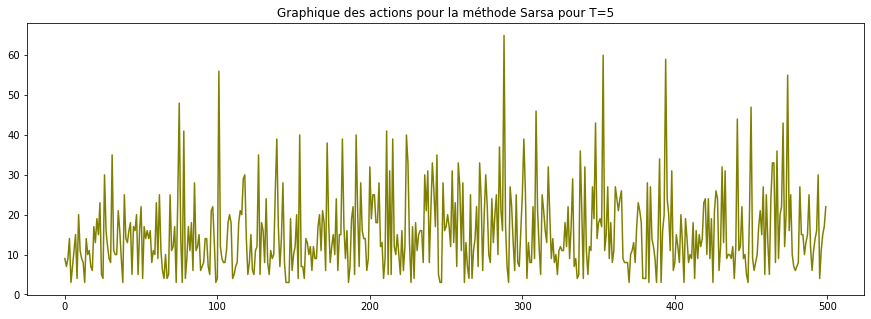

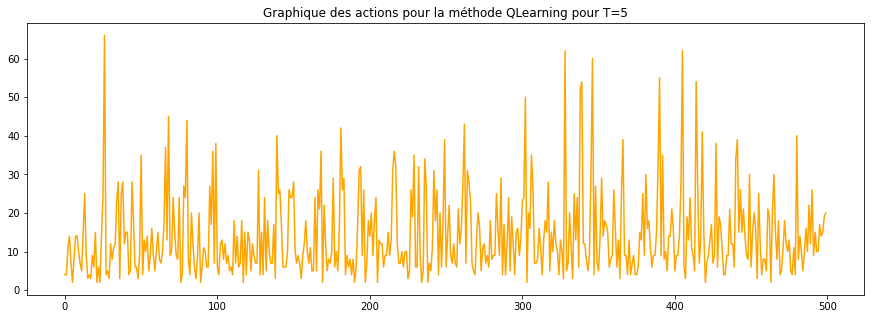

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour T=5")
plt.show()

##### **Remarques** 

Pour les différentes valeurs d'$\epsilon$ les courbes sont plutôt similaires pour les 3 algorithmes: Monte-Carlo, Sarsa, QLearning.  
La courbe des actions oscille entre 0 et 100, quant à la courbe des gains elle est putôt fixe à une valeur (0 ou 1). 

### **Environnement FoorRooms_Key**

Nous avons rencontré des temps de traitement très grand dans cette partie, ainsi, afin de respecter la deadline, nous avons fait varier le nombre d'épisodes à 10.

In [ ]:
env=base.FoorRooms_Key()

#### **a. Exploration e-greedy**

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo(env, 0.5, 10, 0.9, 5)
q_sarsa,recomp_sarsa,action_sarsa=sarsa(env, 0.9, 0.1, 10,0.9, 5)
q_qlearning,recomp_qlearning,action_qlearning=qlearning(env, 0.9, 0.1, 10,0.9, 5)

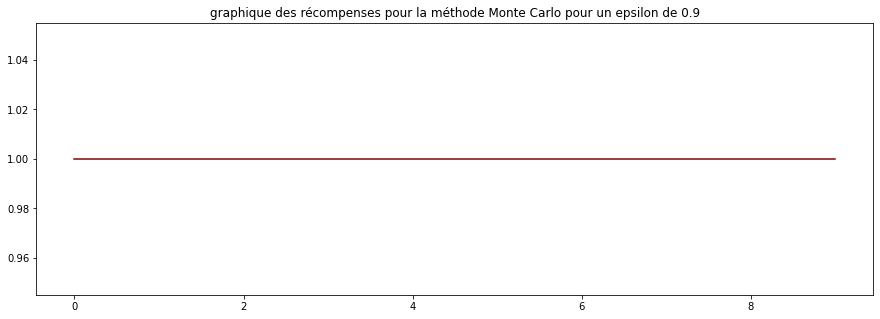

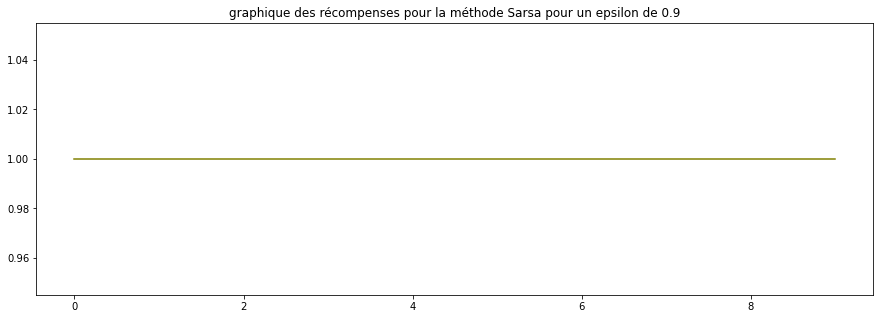

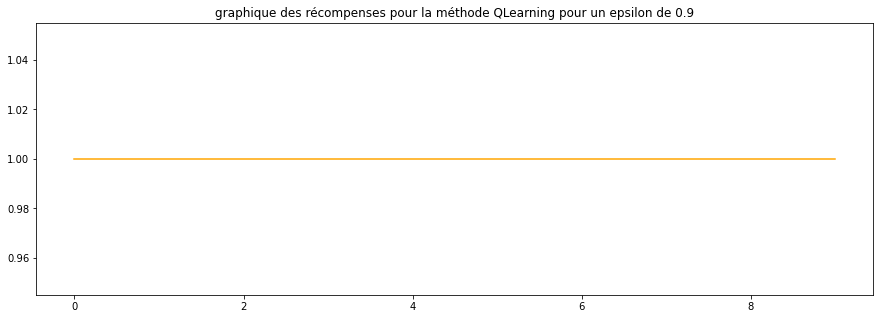

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("graphique des récompenses pour la méthode Monte Carlo pour un epsilon de 0.9")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("graphique des récompenses pour la méthode Sarsa pour un epsilon de 0.9")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("graphique des récompenses pour la méthode QLearning pour un epsilon de 0.9")
plt.show()

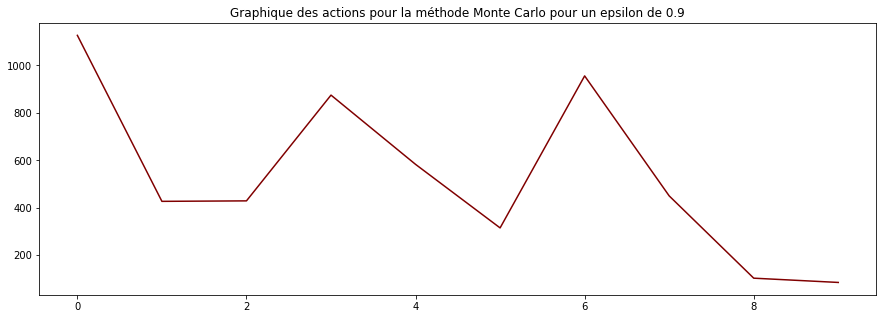

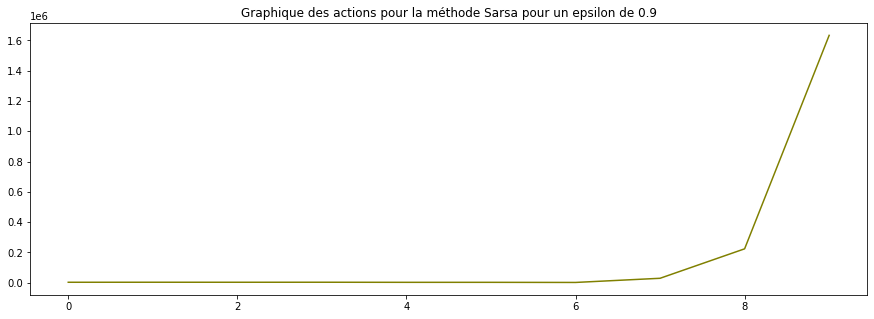

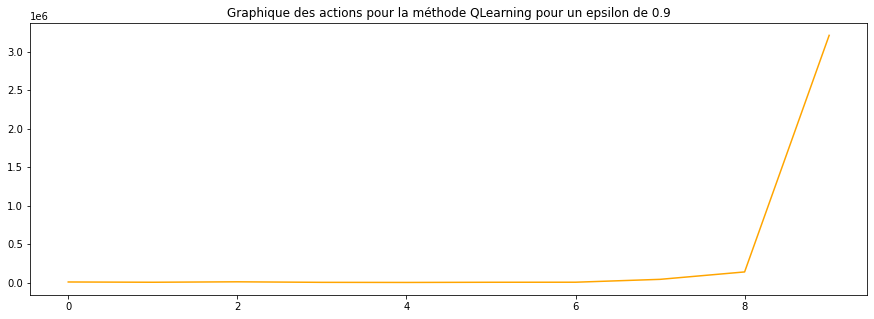

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour un epsilon de 0.9")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour un epsilon de 0.9")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour un epsilon de 0.9")
plt.show()

#### **b. Exploration softmax**

##### **T=5**

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo_softmax(env, 0.5, 10, 5)
q_sarsa,recomp_sarsa,action_sarsa=sarsa_softmax(env, 0.9, 0.1, 10, 5)
q_qlearning,recomp_qlearning,action_qlearning=qlearning_softmax(env, 0.9, 0.1, 10, 5)

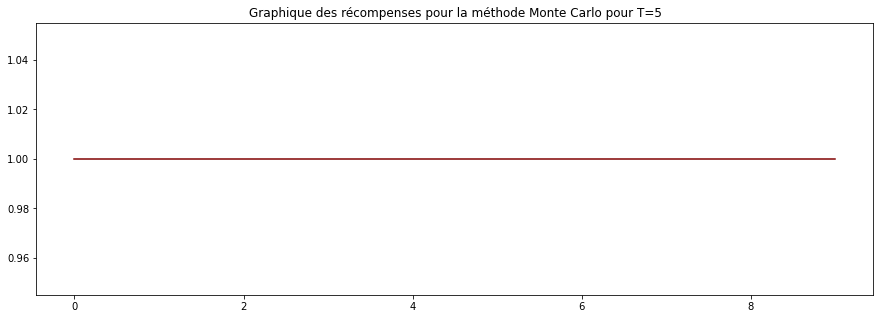

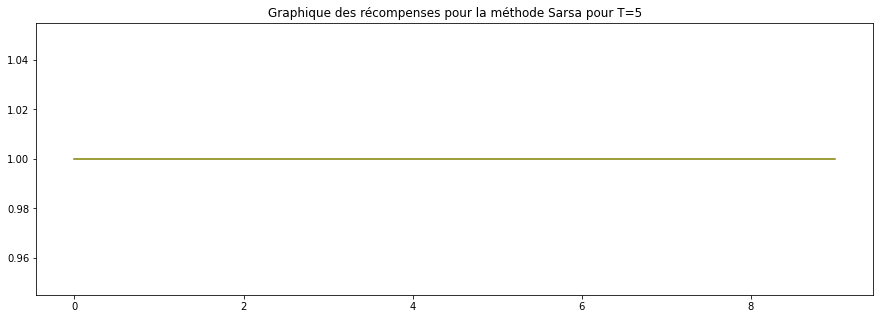

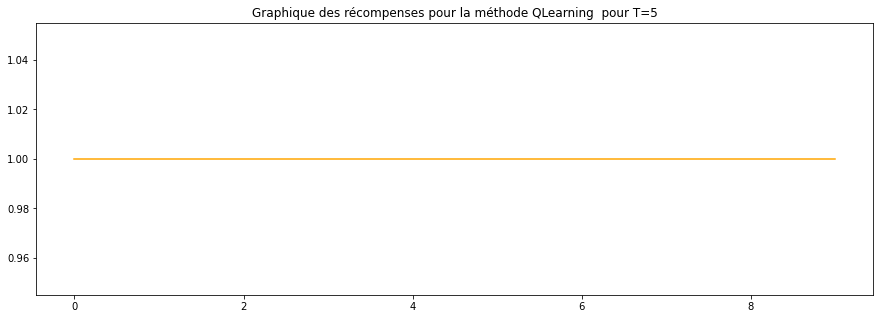

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("Graphique des récompenses pour la méthode Monte Carlo pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("Graphique des récompenses pour la méthode Sarsa pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("Graphique des récompenses pour la méthode QLearning  pour T=5")
plt.show()

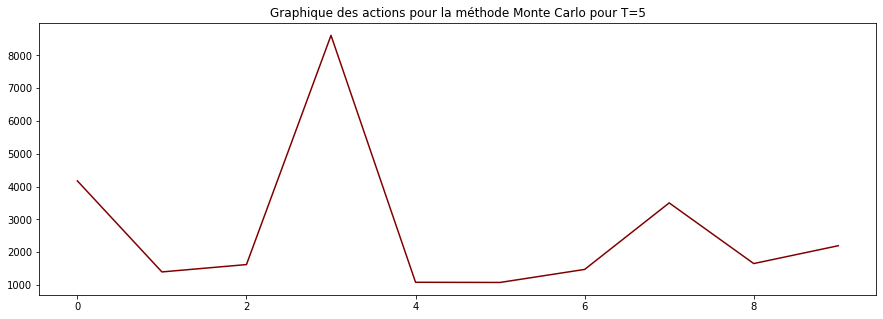

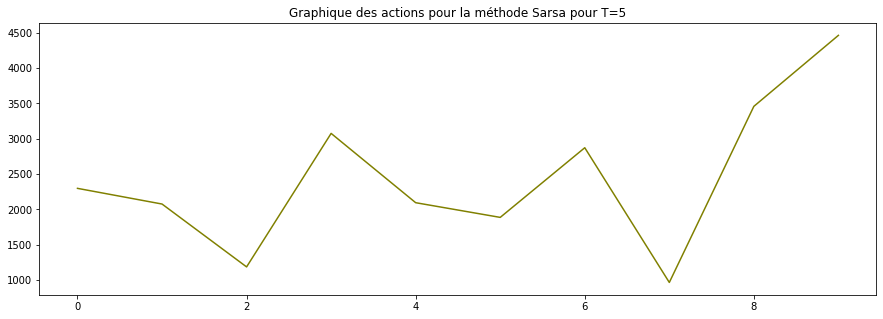

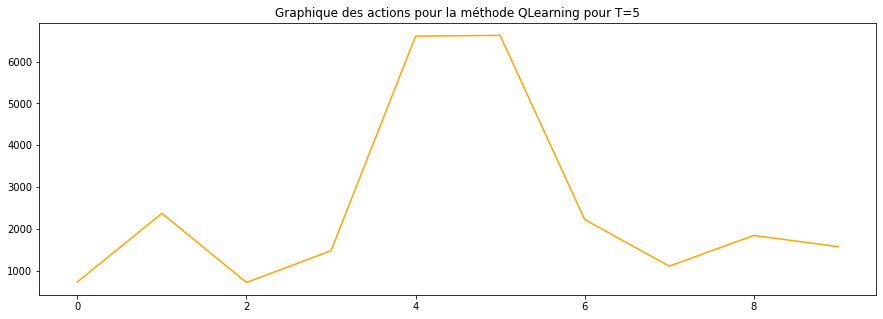

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour T=5")
plt.show()

##### **T=20**

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo_softmax(env, 0.5, 10, 20)
q_sarsa,recomp_sarsa,action_sarsa=sarsa_softmax(env, 0.9, 0.1, 10, 20)
q_qlearning,recomp_qlearning,action_qlearning=qlearning_softmax(env, 0.9, 0.1, 10, 20)

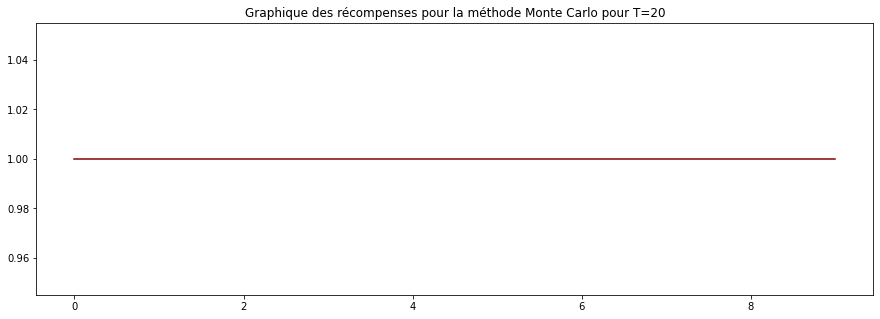

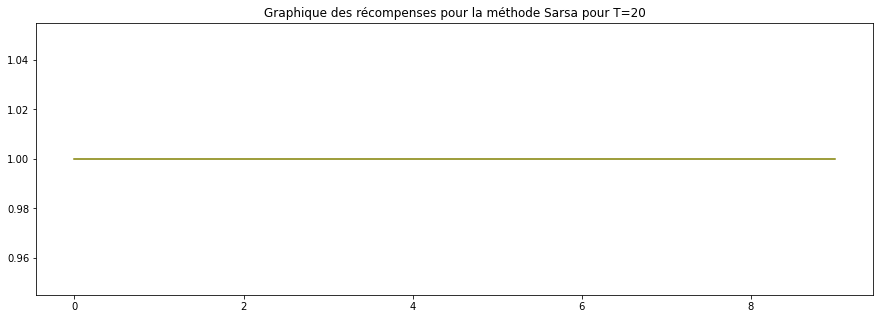

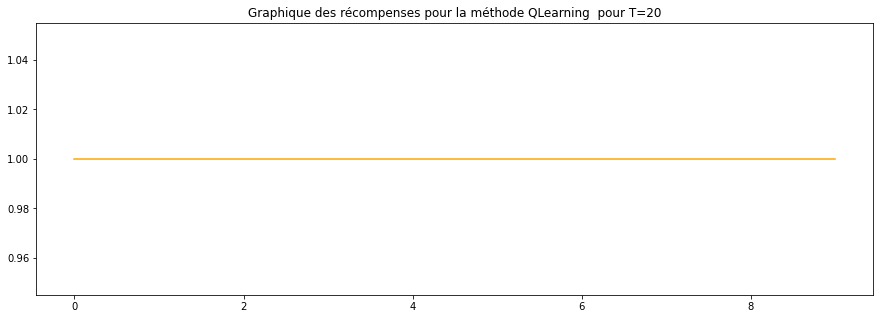

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("Graphique des récompenses pour la méthode Monte Carlo pour T=20")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("Graphique des récompenses pour la méthode Sarsa pour T=20")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("Graphique des récompenses pour la méthode QLearning  pour T=20")
plt.show()

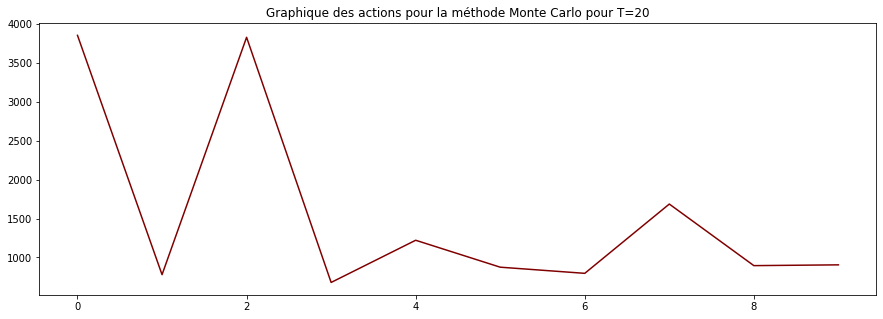

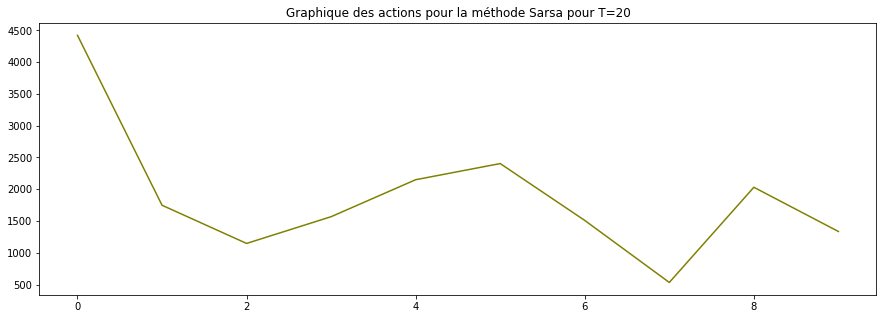

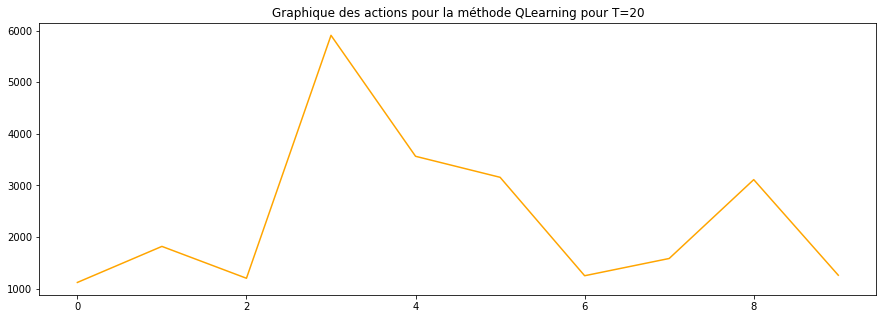

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour T=20")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour T=20")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour T=20")
plt.show()

##### **T=100**

In [ ]:
q_monte_carlo,recomp_monte_carlo,action_monte_carlo=monte_carlo_softmax(env, 0.5, 10, 100)
q_sarsa,recomp_sarsa,action_sarsa=sarsa_softmax(env, 0.9, 0.1, 10, 100)
q_qlearning,recomp_qlearning,action_qlearning=qlearning_softmax(env, 0.9, 0.1, 10, 100)

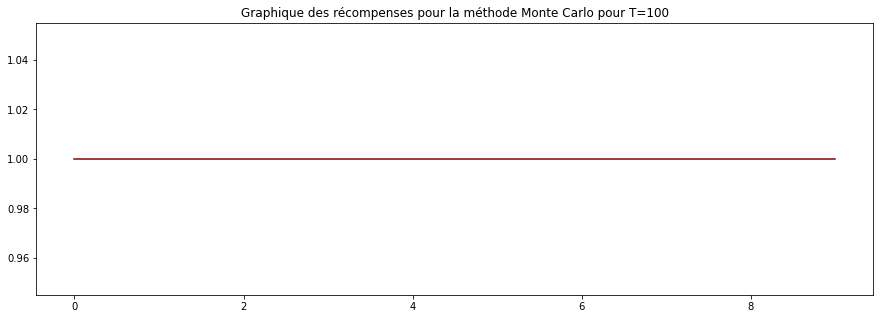

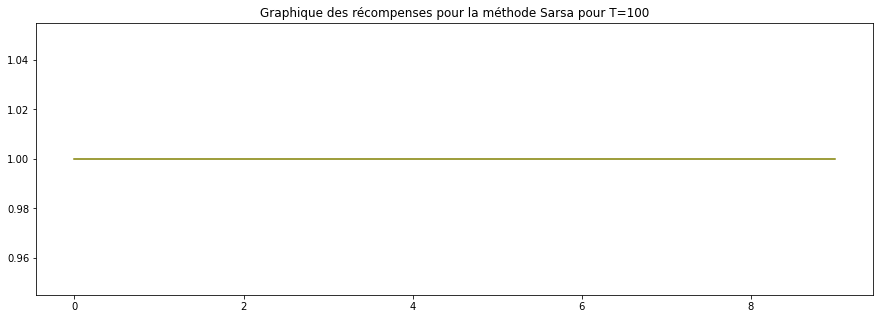

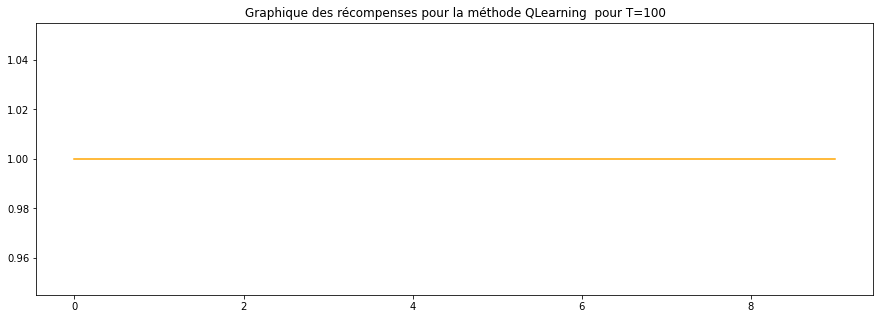

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_monte_carlo, color="maroon")
plt.title("Graphique des récompenses pour la méthode Monte Carlo pour T=100")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("Graphique des récompenses pour la méthode Sarsa pour T=100")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("Graphique des récompenses pour la méthode QLearning  pour T=100")
plt.show()

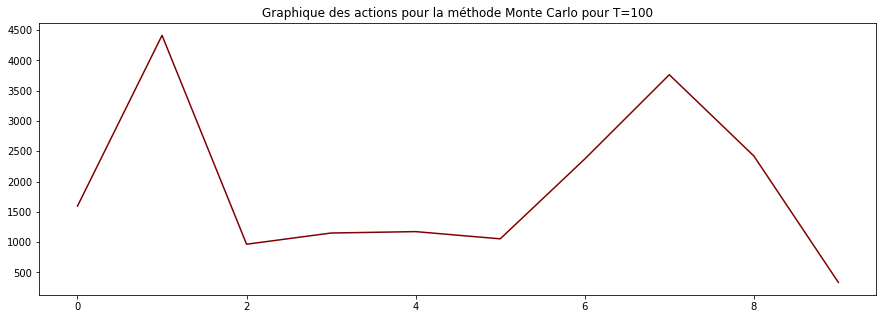

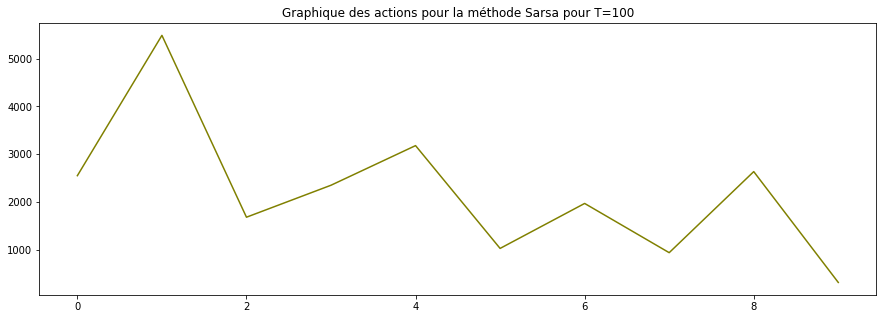

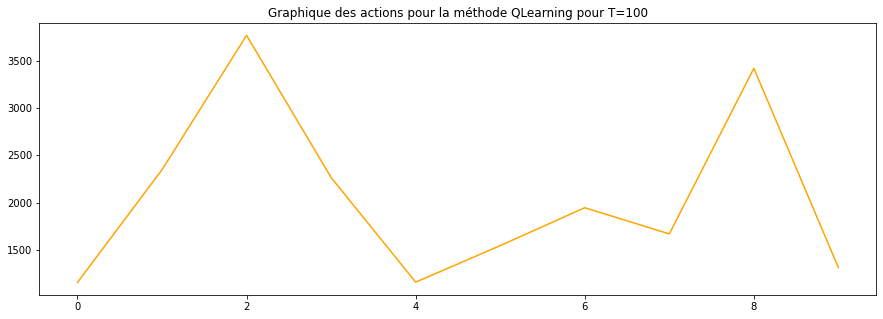

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_monte_carlo, color="maroon")
plt.title("Graphique des actions pour la méthode Monte Carlo pour T=100")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour T=100")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour T=100")
plt.show()

#### **c. Exploration greedy avec une exploration optimiste**

In [ ]:
q_sarsa,recomp_sarsa,action_sarsa=sarsa_optimiste(env, 0.9, 0.1, 10)
q_qlearning,recomp_qlearning,action_qlearning=qlearning_optimiste(env, 0.9, 0.1, 10)

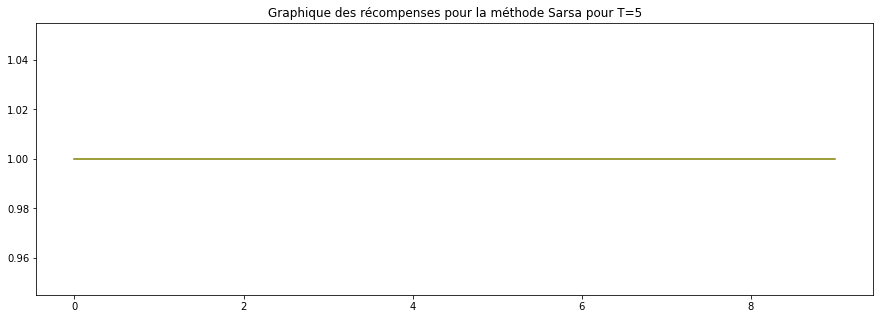

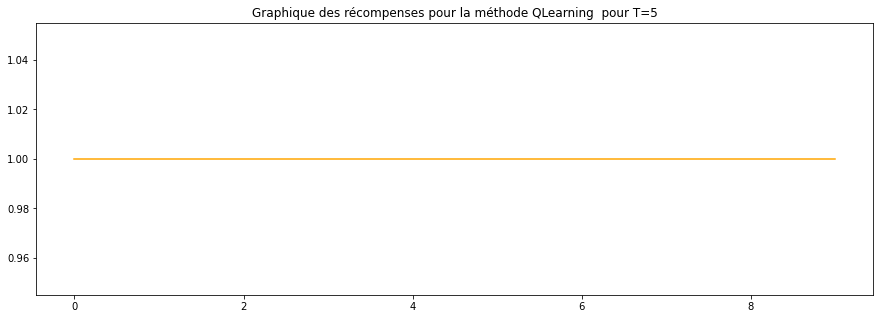

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(recomp_sarsa, color="olive")
plt.title("Graphique des récompenses pour la méthode Sarsa pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(recomp_qlearning, color="orange")
plt.title("Graphique des récompenses pour la méthode QLearning  pour T=5")
plt.show()

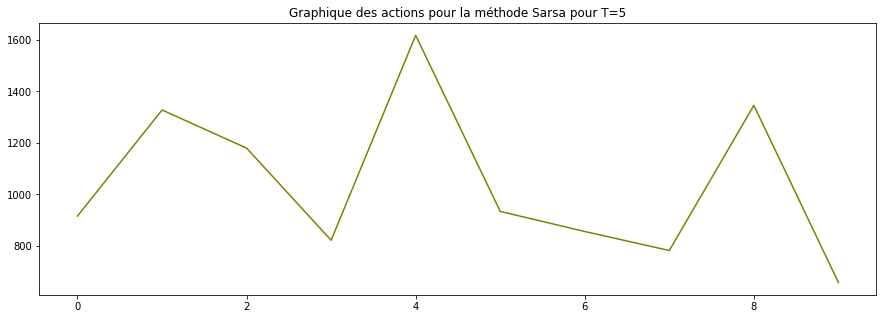

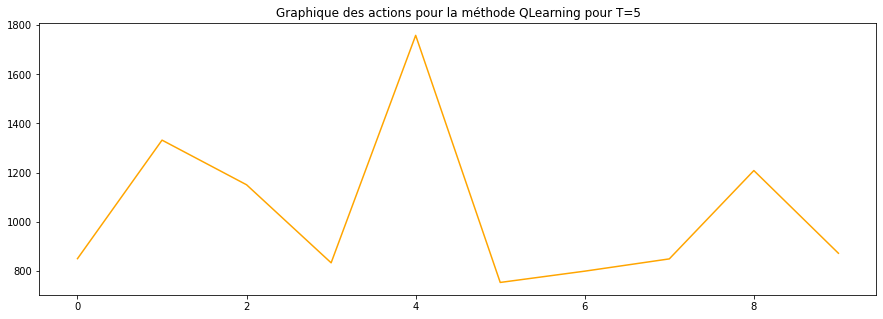

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(action_sarsa, color="olive")
plt.title("Graphique des actions pour la méthode Sarsa pour T=5")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(action_qlearning, color="orange")
plt.title("Graphique des actions pour la méthode QLearning pour T=5")
plt.show()